# Ask

Build a model to predict which active merchants are most likely to churn in the near future

# Reasons for Churn

There are three reasons for a merchant to churn:
- Their business goes under, and they're no longer processing payments anywhere
    - Maybe they're not doing as well as before, in which case we'd see a steady decline in volume, transaction count, and transaction frequency over time, usually for merchants who've been around for a while
    - Maybe their business never really took off, and we'd see lower values for transaction volume and counts, usually for younger merchants
- They're no longer processing payments online
    - Either their online business is struggling or they no longer want to handle the overhead - usually a combination of the two. The data points above would apply here as well, though we wouldn't capture the case where their brick and mortar business is doing well enough to not require an online component any longer
- They move to a different payment processor or build in house (the latter is unlikely)
    - Merchants may want better pricing, support, additional features or discounts. We would see a sudden drop in transaction volume and counts
    - This change may happen due to the two reasons above as margins get tight
    - It may also happen as the business starts doing well, and starts to optimize its spend, in which case we'd see a steady increase in volume etc.
 
We'll try to model all of these cases to the extent that we can with the data that we have. 

# Approach

In order to capture merchant's changing circumstances over time, we'll have to model the problem as a series of sliding time windows.

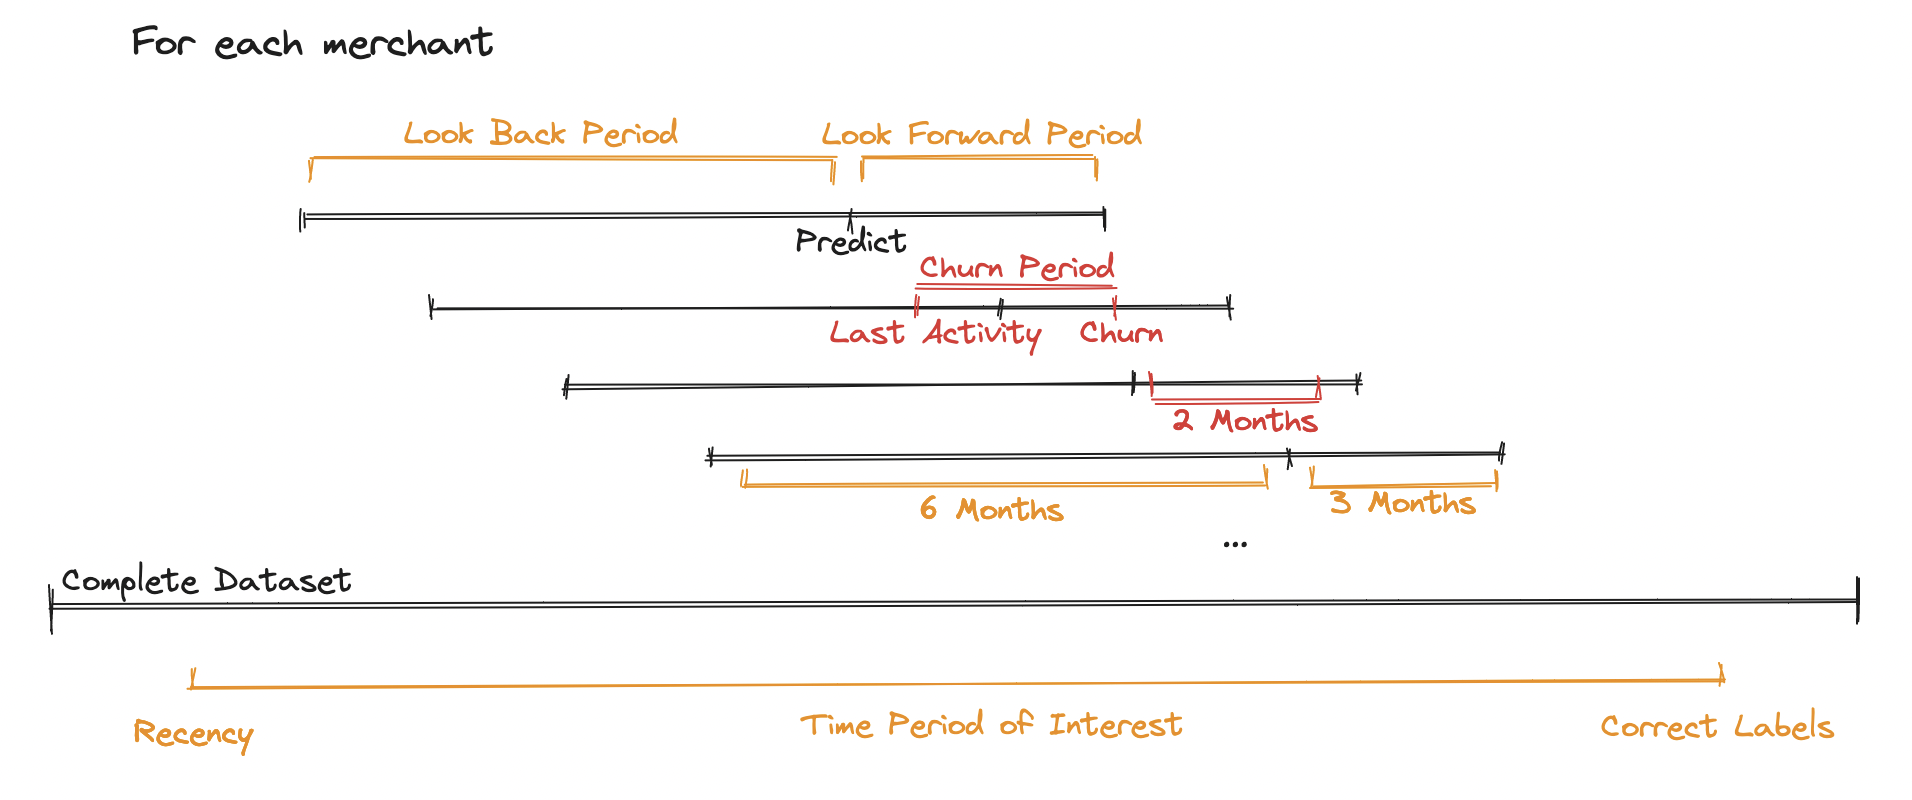

In [115]:
from IPython.display import Image
from IPython.core.display import HTML

Image(filename = "images/sliding_windows.png")

Each time we make a prediction for a merchant, we determine whether they are likely to churn in the `look_forward_period`. We use data from the `look_back_period` to determine the likelihood of them churning. The `churn_period`, or the number of days they have to go without activity to be marked as churned, can be the same as the `look_forward_period`, or slightly shorter, in case we want to get ahead of things by identifying at risk merchants sooner. The merchant's last activity can happen either before we make the prediction, or after, so long as the `churn_period` is shorter than the `look_forward_period`. We'll model both cases. We can also vary how frequently we make a prediction, given by the `prediction_frequency`.

Each observation therefore, will be a `merchant--period` combination.

The values for `prediction_frequency`, `look_forward_period`, `look_back_period`, and `churn_period` are best determined empirically based on the problem at hand, and the selection of these values needs to strike a balance between multiple forces:

`prediction_frequency`: This will depend on how much the underlying dynamics change over time, and how quickly we need to identify at risk merchants. The more things change in a short period of time, the sooner we need to predict at risk merchants, the higher this frequency

`look_forward_period`: This needs to be long enough to give the merchants a chance to churn such that the probability of the churn occurring in the given period isn't prohibitively low. For instance, we could try to predict if a merchant will churn tomorrow, but the probability of that happening is very similar to that happening two days, or a week from now, or even yesterday. This will make the model's job very difficult, asking it to predict the likelihood of churn in a longer period (weeks, months), is much easier. This also needs to be balanced with the need to identify at risk merchants sooner, so that we actually have time to retain them

`look_back_period`: If we look too far back, and don't generate our metrics correctly for that historical period, we risk contaminating relevant data that indicates that a merchant is likely to churn with data from when that merchant was successful and happy on our platform. On the other hand, if we don't look far enough, we risk not capturing the change we need to observe to indicate churn

`churn_period`: While this can be the same as the `look_forward_period`, it's good to make it a little shorter to get ahead of churn risks so that we can try to retain the merchants.

We cannot use the last `look_forward_period` of the data, since the labels won't be reliable - merchant that were going to churn will not have had a chance to do so yet. We'll also limit how far back in the data we go, not wanting trends from a year or more ago to influence our models current decision making.

Following empirical results, we eventually chose `prediction_frequency: 1 month`, `look_forward_period: 3 months`, `look_back_period: 6 months`, and `churn_period: 2 months` respectively. The `churn_period` is a little shorter than the `churn_period` selected in the preceding Churn definition exercise, but as discussed there as well, this is by design.

Other values tested are listed during the modeling below.

# Setup

## Installs and Imports

In [1]:
import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from lib.visualization import format_plot, compare_dist, plot_precision_recall_curve
from lib.labels import generate_labels
from lib import feature_engineering as fe
from lib.modeling import train_test_split, eval_classification

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Config

### I/O

In [2]:
DATA_DIR = 'data/'
DATA_FILE = 'data_cleaned.csv'

MERCHANT_TYPES_FILE = 'merchant_types.csv'

OUT_DIR = 'output/'
OUT_FILE = 'merchant_churn_likelihood.csv'

## Featureset

In [3]:
CHURN_PERIOD = 60 #30, 60, 90
PREDICTION_FREQUENCY = "M" #"W", "2W", "M", "Q"
LOOKFORWARD_PERIOD_DAYS = 90 #30, 60, 90, 180
LOOKBACK_PERIOD_DAYS = 90 #90, 180
AGE_CUTOFF_DAYS = 14

## Modeling

In [4]:
RANDOM_SEED = 42

TRAIN_START = '2033-06-01'
VAL_START = '2034-06-01'
TEST_START = '2034-08-01'
TEST_END = '2034-09-30'

## Visualization

In [5]:
# Interpretability
shap.initjs()

# Tabular
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

# Plots
plt.rcParams['figure.figsize'] = [15, 3]

# Warnings
import warnings; warnings.filterwarnings(action='ignore')

# Read in Data

In [6]:
data = pd.read_csv(DATA_DIR + DATA_FILE)
print(f"Dimensions: {data.shape}")
data.head()

Dimensions: (1513501, 4)


merchant                 time  amount  time_diff_days
0  0002b63b92  2033-05-16 20:07:57   33.79             NaN
1  0002d07bba  2034-10-11 17:02:26   55.49             NaN
2  0002d07bba  2034-10-17 17:57:32  378.30            6.04
3  0002d07bba  2034-11-13 15:42:55  438.42           26.91
4  0002d07bba  2034-12-15 09:56:19   20.57           31.76

In [7]:
mt = pd.read_csv(OUT_DIR + MERCHANT_TYPES_FILE)
print(f"Dimensions: {mt.shape}")
mt.head()

Dimensions: (14351, 2)


merchant   category
0  0002b63b92  Single Tx
1  0002d07bba    Average
2  00057d4302    Average
3  000bcff341  Single Tx
4  000ddbf0ca  Single Tx

# Preprocessing

In [8]:
data['time'] = pd.to_datetime(data['time'])
data.sort_values(by=['merchant', 'time'], inplace=True)
data_end_cutoff = data['time'].max() - pd.DateOffset(LOOKFORWARD_PERIOD_DAYS)

# Labels

We'll generate labels based on the approach defined above

For each merchant--month combination, we observe churn 25% of the time - this lines up with our finding from the Churn Definition analysis, where we found that merchants come back from a 3 month break approximately 23% of the time

In [9]:
labels = generate_labels(data, 'merchant', 'time', PREDICTION_FREQUENCY, CHURN_PERIOD, LOOKFORWARD_PERIOD_DAYS)
print(labels.shape)

labels = labels[['merchant', 'period', 'lfp_start', 'churn']]
labels_ss = labels[labels['period'].dt.end_time < data_end_cutoff]
print(labels_ss['churn'].value_counts(normalize=True))
labels.head()

(77858, 10)
churn
0    0.757799
1    0.242201
Name: proportion, dtype: float64


merchant   period   lfp_start  churn
0  0002b63b92  2033-05  2033-06-01      1
1  0002d07bba  2034-10  2034-11-01      0
2  0002d07bba  2034-11  2034-12-01      1
3  0002d07bba  2034-12  2035-01-01      1
4  00057d4302  2033-05  2033-06-01      0

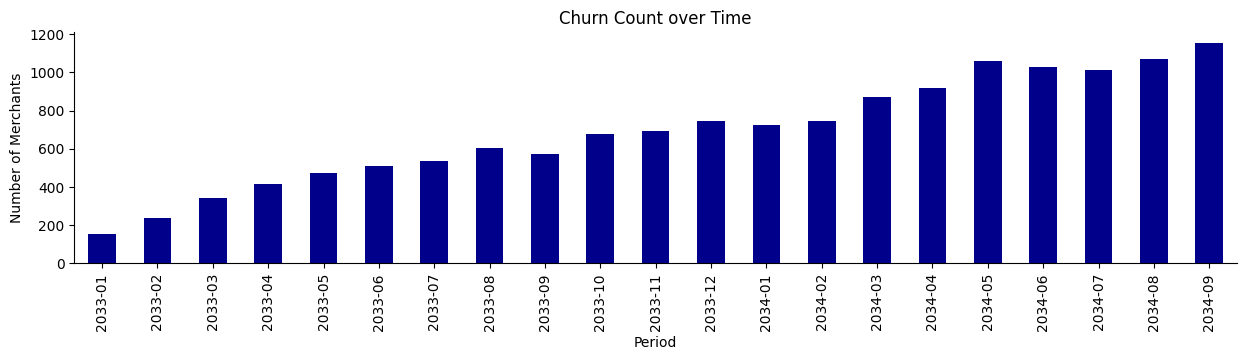

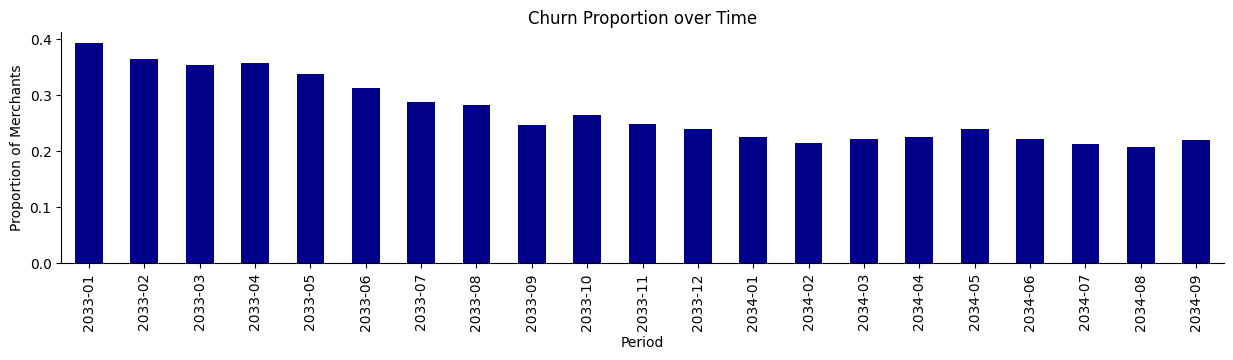

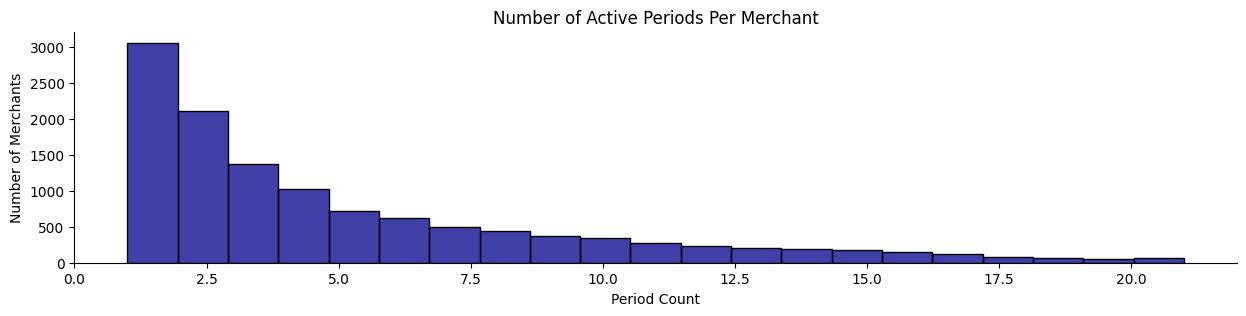

In [10]:
labels_ss.groupby('period')['churn'].sum().plot.bar(color='darkblue')
format_plot("Churn Count over Time", "Period", "Number of Merchants")

(labels_ss.groupby('period')['churn'].sum() / labels_ss.groupby('period')['churn'].count()).plot.bar(color='darkblue')
format_plot("Churn Proportion over Time", "Period", "Proportion of Merchants")

sns.histplot(data=labels_ss.groupby('merchant')['period'].count(), bins=21, color='darkblue')
format_plot("Number of Active Periods Per Merchant", "Period Count", "Number of Merchants")

The number of merchants churning over time is going up as the platform grows, but the proportion churning is going down. It's also interesting to note that most merchants spend less than 6 unique months on the platform, indicating that a month is a good prediction frequency to follow - a quarter would have been too long.

# Features

## Features to Evaluate

To capture the indicators of churn enumerated above, and the data available, we'll engineer the following sets of features for each merchant--period combination

- Metadata
    - Account Age
- Base Aggregates for the current period (prediction will be made at period end)
    - Total Transaction Volume
    - Tx Amount (min, max, mean, median, std)
    - Number of Transactions
    - Tx Frequency (min, max, mean, median, std)
- Trailing aggregates
    - For all the  base aggregates
- Proportional Changes
    - For all the base aggregates
    - Compared to the previous, and last two periods
    - Compared to the historical peak
    - Compared to 3 months ago, and six month ago
    - YoY
- Max Historical Tx Frequency

We could also look at whether they've churned before, but that risks introducing leakage, so we'll use the Max Historical Transaction Frequency as proxy

Given the steadily rising trend on almost all metrics, we'll need to normalize these values by assigning merchants ranks within periods. This is particularly important for any algorithm that makes decisions based on absolute cutoffs, since those cutoffs will be evolving over time.

We could also have included the merchant types we derived earlier as features, but since the clusters are calculated on the entire dataset, that would introduce leakage, so we'll leave them out for now. Going forward if clusters are calculated on an ongoing basis, they can be added to the model in a point in time correct manner.

## Accounts/Observations to filter out

We'll remove very young accounts, less than 14 days old, since there isn't enough data for us to make any sort of determination about them.

We could also remove accounts with a single transaction, those with very low volume, or those with bouts of very high ransaction frequency. These may be test accounts, but nothing about them clearly points to them being inorganic, and we wouldn't want to remove them without being absolutely sure. Since we can't ask folks who might know, we'll assume they're legitimate and leave them in for now.

## Feature Engineering

We can approach this in two ways - generate a lot of features, most of which will be highly correlated, and let the model decide which ones to keep, or keep a running tab of seemingly relevant features based on univariate analysis. The former is preferable, but in this case given the simplicity of the data, there likely won't be much difference in performance across the two approaches, so we'll do both as an interesting exercise.

We'll have to be very careful while engineering features to make sure there's no leakage.

In [11]:
dataset = labels[['merchant', 'period', 'lfp_start', 'churn']]
print(dataset.shape)

(77858, 4)


We'll keep track of features that seem interesting

In [12]:
features_of_interest = []

### Metadata

<!-- Younger accounts seem to churn more frequently -->

In [13]:
merchant_start = data.groupby('merchant')['time'].min().reset_index().rename(columns={'time': 'merchant_min_ts'})
dataset = dataset.merge(merchant_start, on='merchant')
dataset['merchant_age'] = round((pd.to_datetime(dataset['lfp_start']) - dataset['merchant_min_ts']).dt.total_seconds() / (3600 * 24), 1)
dataset.drop('merchant_min_ts', axis=1, inplace=True)
dataset.shape

(77858, 5)

In [14]:
dataset = dataset[dataset['merchant_age'] > 14]
dataset.shape

(71540, 5)

In [15]:
dataset = fe.assign_rank(dataset, ['merchant_age'], 'period')
print(dataset.shape)
dataset.head()

(71540, 6)


merchant   period   lfp_start  churn  merchant_age  merchant_age_rank
0  0002b63b92  2033-05  2033-06-01      1          15.2                2.0
1  0002d07bba  2034-10  2034-11-01      0          20.3                3.1
2  0002d07bba  2034-11  2034-12-01      1          50.3               11.6
3  0002d07bba  2034-12  2035-01-01      1          81.3               18.2
5  00057d4302  2033-08  2033-09-01      1          93.9               51.7

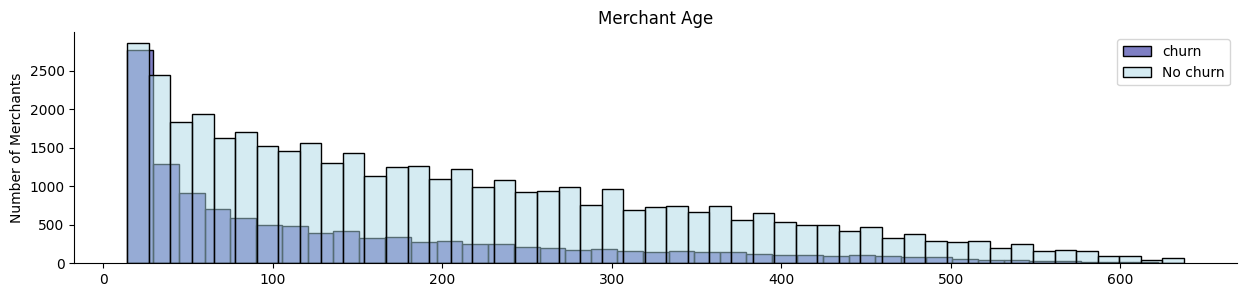

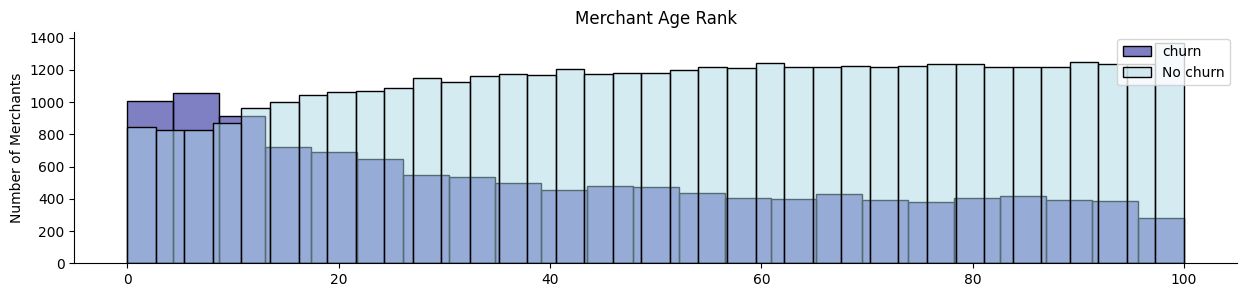

In [16]:
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'merchant_age', 'churn', 'Merchant Age', '', 'Number of Merchants')
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'merchant_age_rank', 'churn', 'Merchant Age Rank', '', 'Number of Merchants')

It's possible that merchants signed on to the platform prior to the data range available, but given the trajectory of platform growth from the initial exploration that seems unlikely. 

Younger merchants seem to churn at higher rates

In [17]:
features_of_interest.append(['merchant_age', 'merchant_age_rank'])

### Most Recent Period

#### Aggregates

In [18]:
merchant_metrics = data.groupby(['merchant', 'period']).agg({
    'amount': ['sum', 'count', 'mean', 'median', 'std', 'min', 'max'],
    'time_diff_days': ['mean', 'median', 'std', 'min', 'max']
}).reset_index()

merchant_metrics.columns = ['merchant', 
                            'period',
                            'total_tx_volume', 
                            'tx_count', 
                            'avg_tx_amount', 
                            'median_tx_amount', 
                            'std_tx_amount', 
                            'min_tx_amount',
                            'max_tx_amount',
                            'avg_tx_freq', 
                            'median_tx_freq', 
                            'std_tx_freq', 
                            'min_tx_freq', 
                            'max_tx_freq']

merchant_metrics.fillna(-1, inplace=True)
print(merchant_metrics.shape)
merchant_metrics.head()

(77858, 14)


merchant   period  total_tx_volume  tx_count  avg_tx_amount  \
0  0002b63b92  2033-05            33.79         1      33.790000   
1  0002d07bba  2034-10           433.79         2     216.895000   
2  0002d07bba  2034-11           438.42         1     438.420000   
3  0002d07bba  2034-12            20.57         1      20.570000   
4  00057d4302  2033-05           203.86        17      11.991765   

   median_tx_amount  std_tx_amount  min_tx_amount  max_tx_amount  avg_tx_freq  \
0            33.790      -1.000000          33.79          33.79    -1.000000   
1           216.895     228.261140          55.49         378.30     6.040000   
2           438.420      -1.000000         438.42         438.42    26.910000   
3            20.570      -1.000000          20.57          20.57    31.760000   
4             7.420       9.775618           6.05          40.73     0.006875   

   median_tx_freq  std_tx_freq  min_tx_freq  max_tx_freq  
0          -1.000    -1.000000        -1.00        -1.00  
1           6.040    -1.000000         6.04         6.04  
2          26.910    -1.000000        26.91        26.91  
3          31.760    -1.000000        31.76        31.76  
4           0.005     0.008732         0.00         0.03

In [19]:
dataset = dataset.merge(merchant_metrics, on=['merchant', 'period'])
print(dataset.shape)
dataset.head()

(71540, 18)


merchant   period   lfp_start  churn  merchant_age  merchant_age_rank  \
0  0002b63b92  2033-05  2033-06-01      1          15.2                2.0   
1  0002d07bba  2034-10  2034-11-01      0          20.3                3.1   
2  0002d07bba  2034-11  2034-12-01      1          50.3               11.6   
3  0002d07bba  2034-12  2035-01-01      1          81.3               18.2   
4  00057d4302  2033-08  2033-09-01      1          93.9               51.7   

   total_tx_volume  tx_count  avg_tx_amount  median_tx_amount  std_tx_amount  \
0            33.79         1      33.790000            33.790      -1.000000   
1           433.79         2     216.895000           216.895     228.261140   
2           438.42         1     438.420000           438.420      -1.000000   
3            20.57         1      20.570000            20.570      -1.000000   
4            91.35        11       8.304545             7.680       1.607597   

   min_tx_amount  max_tx_amount  avg_tx_freq  median_tx_freq  std_tx_freq  \
0          33.79          33.79    -1.000000           -1.00    -1.000000   
1          55.49         378.30     6.040000            6.04    -1.000000   
2         438.42         438.42    26.910000           26.91    -1.000000   
3          20.57          20.57    31.760000           31.76    -1.000000   
4           7.42          12.48     5.999091            0.01    19.850304   

   min_tx_freq  max_tx_freq  
0        -1.00        -1.00  
1         6.04         6.04  
2        26.91        26.91  
3        31.76        31.76  
4         0.00        65.85

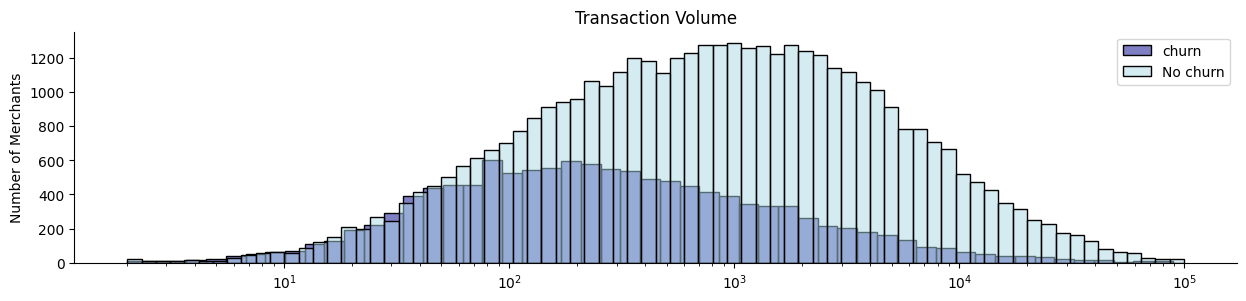

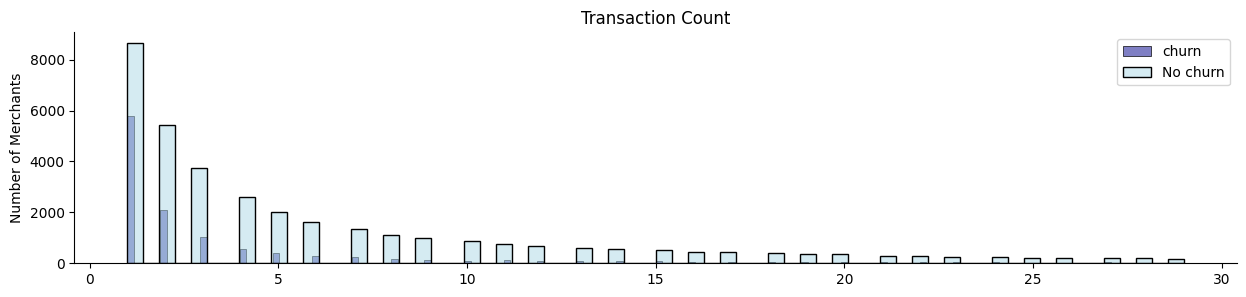

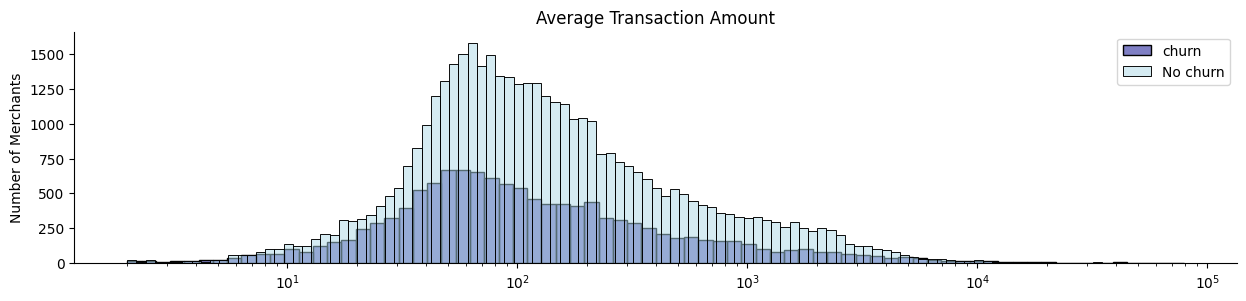

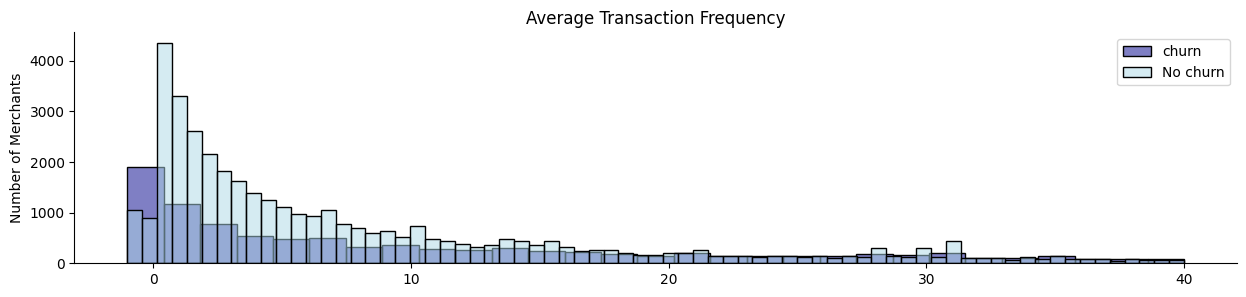

In [20]:
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'total_tx_volume', 'churn', 'Transaction Volume', '', 'Number of Merchants', cutoff=100000, log_scale=True)
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'tx_count', 'churn', 'Transaction Count', '', 'Number of Merchants', cutoff=30)
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'avg_tx_amount', 'churn', 'Average Transaction Amount', '', 'Number of Merchants', cutoff=100000, log_scale=True)
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'avg_tx_freq', 'churn', 'Average Transaction Frequency', '', 'Number of Merchants', cutoff=40, log_scale=False)

#### Ranks

In [21]:
base_aggregate_cols = [c for c in dataset.columns if 'tx' in c]
dataset = fe.assign_rank(dataset, base_aggregate_cols, 'period')
print(dataset.shape)
dataset.head()

(71540, 30)


merchant   period   lfp_start  churn  merchant_age  merchant_age_rank  \
0  0002b63b92  2033-05  2033-06-01      1          15.2                2.0   
1  0002d07bba  2034-10  2034-11-01      0          20.3                3.1   
2  0002d07bba  2034-11  2034-12-01      1          50.3               11.6   
3  0002d07bba  2034-12  2035-01-01      1          81.3               18.2   
4  00057d4302  2033-08  2033-09-01      1          93.9               51.7   

   total_tx_volume  tx_count  avg_tx_amount  median_tx_amount  std_tx_amount  \
0            33.79         1      33.790000            33.790      -1.000000   
1           433.79         2     216.895000           216.895     228.261140   
2           438.42         1     438.420000           438.420      -1.000000   
3            20.57         1      20.570000            20.570      -1.000000   
4            91.35        11       8.304545             7.680       1.607597   

   min_tx_amount  max_tx_amount  avg_tx_freq  median_tx_freq  std_tx_freq  \
0          33.79          33.79    -1.000000           -1.00    -1.000000   
1          55.49         378.30     6.040000            6.04    -1.000000   
2         438.42         438.42    26.910000           26.91    -1.000000   
3          20.57          20.57    31.760000           31.76    -1.000000   
4           7.42          12.48     5.999091            0.01    19.850304   

   min_tx_freq  max_tx_freq  total_tx_volume_rank  tx_count_rank  \
0        -1.00        -1.00                   4.9           13.6   
1         6.04         6.04                  40.8           32.1   
2        26.91        26.91                  39.8           11.3   
3        31.76        31.76                   2.2           12.3   
4         0.00        65.85                  16.7           76.1   

   avg_tx_amount_rank  median_tx_amount_rank  std_tx_amount_rank  \
0                13.4                   16.2                13.6   
1                70.8                   75.1                86.0   
2                83.4                   86.0                11.3   
3                 4.6                    5.8                12.3   
4                 1.2                    1.5                31.1   

   min_tx_amount_rank  max_tx_amount_rank  avg_tx_freq_rank  \
0                38.3                 8.9               4.3   
1                56.8                66.6              49.3   
2                90.4                69.2              80.3   
3                26.1                 3.5              85.2   
4                 6.2                 2.4              50.3   

   median_tx_freq_rank  std_tx_freq_rank  min_tx_freq_rank  max_tx_freq_rank  
0                  4.3              15.4               4.3               4.3  
1                 55.4              13.5              68.5              24.0  
2                 81.6              12.0              84.7              70.4  
3                 86.1              12.9              88.3              79.7  
4                  7.3              94.0              13.2              92.6

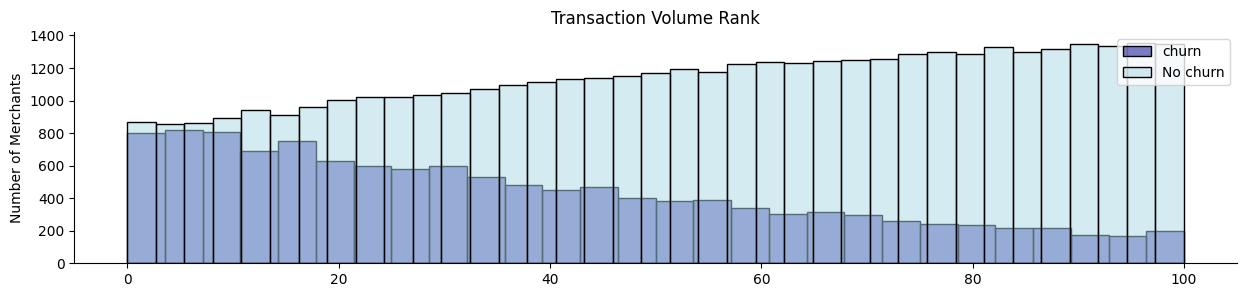

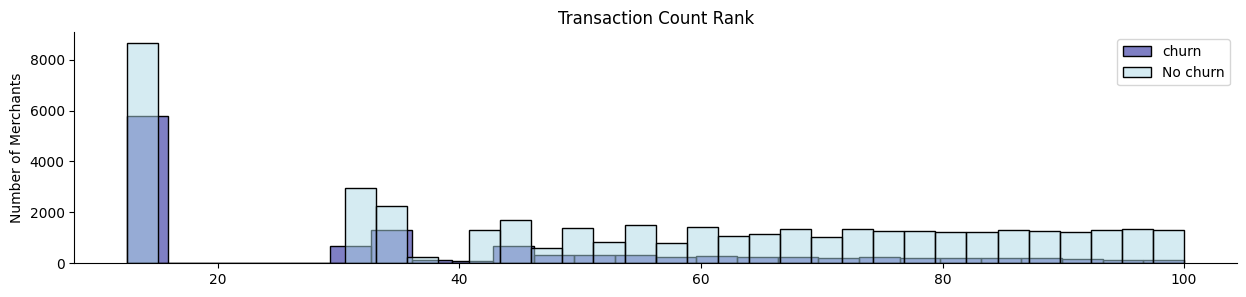

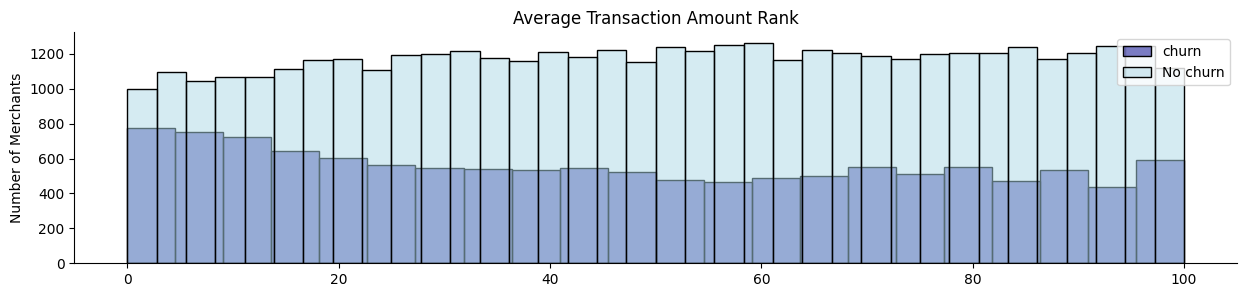

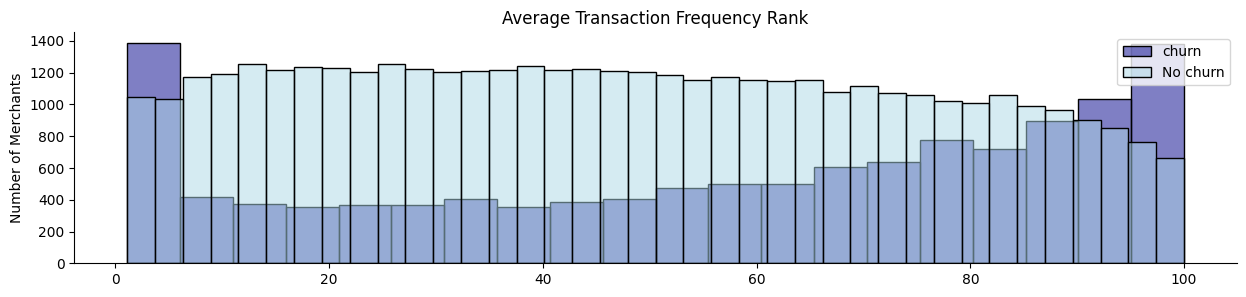

In [22]:
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'total_tx_volume_rank', 'churn', 'Transaction Volume Rank', '', 'Number of Merchants')
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'tx_count_rank', 'churn', 'Transaction Count Rank', '', 'Number of Merchants')
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'avg_tx_amount_rank', 'churn', 'Average Transaction Amount Rank', '', 'Number of Merchants')
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'avg_tx_freq_rank', 'churn', 'Average Transaction Frequency Rank', '', 'Number of Merchants')

Merchants with lower volume, transaction counts, transaction amounts seem to churn more frequently. Interestingly, merchants with lower and high transaction frequencies churn more than those in the middle. We'll add these to the features of interest. 

Though we've generated aggregates across other summary statistics (median, std, min etc.), we'll leave those to the model to prioritize.

In [23]:
features_of_interest.append(['total_tx_volume', 'tx_count', 'avg_tx_amount', 'avg_tx_freq', 'total_tx_volume_rank', 'tx_count_rank', 'avg_tx_amount_rank', 'avg_tx_freq_rank'])

### Trailing Period

#### Preprocess

In [24]:
mm_all_periods = fe.get_merchant_metrics_all_periods(merchant_metrics, 'merchant', 'period')
print(mm_all_periods.shape)
mm_all_periods.head()

(344424, 14)


merchant   period  total_tx_volume  tx_count  avg_tx_amount  \
0  0002b63b92  2033-05            33.79       1.0          33.79   
1  0002b63b92  2034-10              NaN       NaN            NaN   
2  0002b63b92  2034-11              NaN       NaN            NaN   
3  0002b63b92  2034-12              NaN       NaN            NaN   
4  0002b63b92  2033-08              NaN       NaN            NaN   

   median_tx_amount  std_tx_amount  min_tx_amount  max_tx_amount  avg_tx_freq  \
0             33.79           -1.0          33.79          33.79         -1.0   
1               NaN            NaN            NaN            NaN          NaN   
2               NaN            NaN            NaN            NaN          NaN   
3               NaN            NaN            NaN            NaN          NaN   
4               NaN            NaN            NaN            NaN          NaN   

   median_tx_freq  std_tx_freq  min_tx_freq  max_tx_freq  
0            -1.0         -1.0         -1.0         -1.0  
1             NaN          NaN          NaN          NaN  
2             NaN          NaN          NaN          NaN  
3             NaN          NaN          NaN          NaN  
4             NaN          NaN          NaN          NaN

#### Aggregates

In [25]:
trailing_columns = ['total_tx_volume', 'tx_count', 'avg_tx_amount',
                    'median_tx_amount', 'std_tx_amount', 'min_tx_amount', 'max_tx_amount',
                    'avg_tx_freq', 'median_tx_freq', 'std_tx_freq', 'min_tx_freq', 'max_tx_freq']
dataset = fe.add_trailing_aggregates(dataset, trailing_columns, 3, 1, prefix="trailing")
dataset.head()

merchant   period   lfp_start  churn  merchant_age  merchant_age_rank  \
0  0002b63b92  2033-05  2033-06-01      1          15.2                2.0   
1  0002d07bba  2034-10  2034-11-01      0          20.3                3.1   
2  0002d07bba  2034-11  2034-12-01      1          50.3               11.6   
3  0002d07bba  2034-12  2035-01-01      1          81.3               18.2   
4  00057d4302  2033-08  2033-09-01      1          93.9               51.7   

   total_tx_volume  tx_count  avg_tx_amount  median_tx_amount  std_tx_amount  \
0            33.79         1      33.790000            33.790      -1.000000   
1           433.79         2     216.895000           216.895     228.261140   
2           438.42         1     438.420000           438.420      -1.000000   
3            20.57         1      20.570000            20.570      -1.000000   
4            91.35        11       8.304545             7.680       1.607597   

   min_tx_amount  max_tx_amount  avg_tx_freq  median_tx_freq  std_tx_freq  \
0          33.79          33.79    -1.000000           -1.00    -1.000000   
1          55.49         378.30     6.040000            6.04    -1.000000   
2         438.42         438.42    26.910000           26.91    -1.000000   
3          20.57          20.57    31.760000           31.76    -1.000000   
4           7.42          12.48     5.999091            0.01    19.850304   

   min_tx_freq  max_tx_freq  total_tx_volume_rank  tx_count_rank  \
0        -1.00        -1.00                   4.9           13.6   
1         6.04         6.04                  40.8           32.1   
2        26.91        26.91                  39.8           11.3   
3        31.76        31.76                   2.2           12.3   
4         0.00        65.85                  16.7           76.1   

   avg_tx_amount_rank  median_tx_amount_rank  std_tx_amount_rank  \
0                13.4                   16.2                13.6   
1                70.8                   75.1                86.0   
2                83.4                   86.0                11.3   
3                 4.6                    5.8                12.3   
4                 1.2                    1.5                31.1   

   min_tx_amount_rank  max_tx_amount_rank  avg_tx_freq_rank  \
0                38.3                 8.9               4.3   
1                56.8                66.6              49.3   
2                90.4                69.2              80.3   
3                26.1                 3.5              85.2   
4                 6.2                 2.4              50.3   

   median_tx_freq_rank  std_tx_freq_rank  min_tx_freq_rank  max_tx_freq_rank  \
0                  4.3              15.4               4.3               4.3   
1                 55.4              13.5              68.5              24.0   
2                 81.6              12.0              84.7              70.4   
3                 86.1              12.9              88.3              79.7   
4                  7.3              94.0              13.2              92.6   

   trailing_total_tx_volume  trailing_tx_count  trailing_avg_tx_amount  \
0                     33.79                1.0               33.790000   
1                    433.79                2.0              216.895000   
2                    872.21                3.0              327.657500   
3                    892.78                4.0              225.295000   
4                     91.35               11.0                8.304545   

   trailing_median_tx_amount  trailing_std_tx_amount  trailing_min_tx_amount  \
0                    33.7900               -1.000000               33.790000   
1                   216.8950              228.261140               55.490000   
2                   327.6575              113.630570              246.955000   
3                   225.2950               75.420380              171.493333   
4                     7.6800                1.607597                7

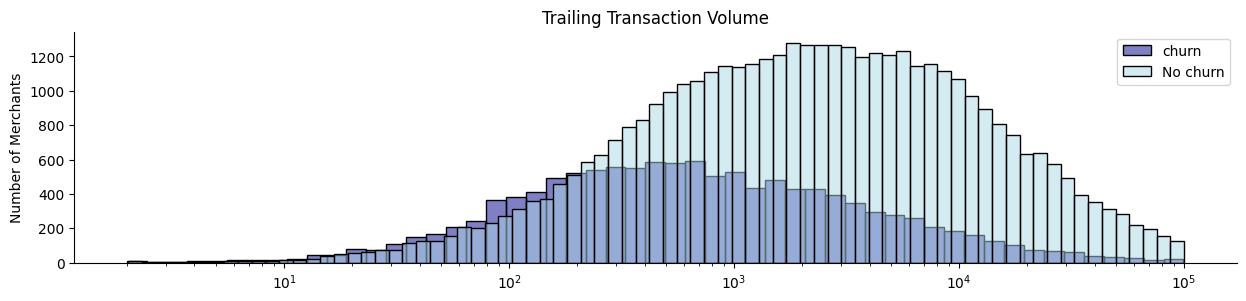

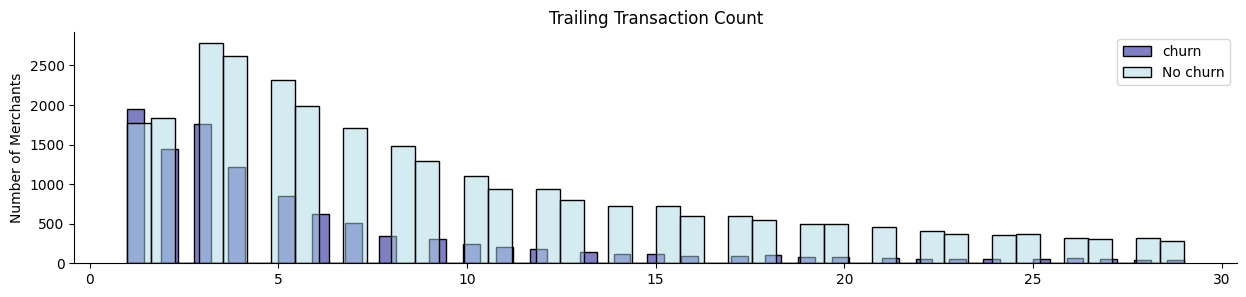

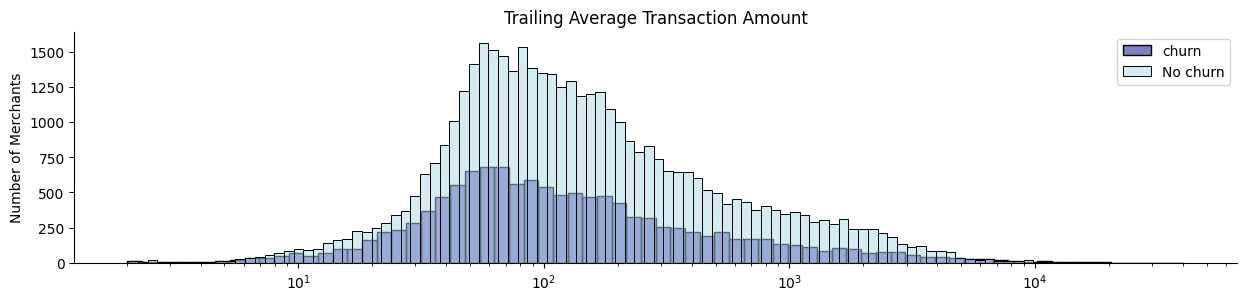

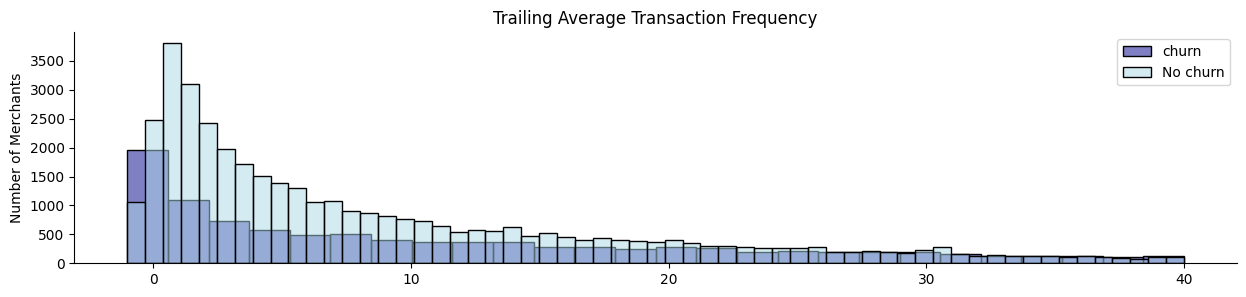

In [26]:
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'trailing_total_tx_volume', 'churn', 'Trailing Transaction Volume', '', 'Number of Merchants', cutoff=100000, log_scale=True)
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'trailing_tx_count', 'churn', 'Trailing Transaction Count', '', 'Number of Merchants', cutoff=30)
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'trailing_avg_tx_amount', 'churn', 'Trailing Average Transaction Amount', '', 'Number of Merchants', cutoff=100000, log_scale=True)
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'trailing_avg_tx_freq', 'churn', 'Trailing Average Transaction Frequency', '', 'Number of Merchants', cutoff=40, log_scale=False)

#### Ranks

In [27]:
aggregate_cols = [c for c in dataset.columns if 'trailing_' in c]
dataset = fe.assign_rank(dataset, aggregate_cols, 'period')
print(dataset.shape)
dataset.head()

(71540, 54)


merchant   period   lfp_start  churn  merchant_age  merchant_age_rank  \
0  0002b63b92  2033-05  2033-06-01      1          15.2                2.0   
1  0002d07bba  2034-10  2034-11-01      0          20.3                3.1   
2  0002d07bba  2034-11  2034-12-01      1          50.3               11.6   
3  0002d07bba  2034-12  2035-01-01      1          81.3               18.2   
4  00057d4302  2033-08  2033-09-01      1          93.9               51.7   

   total_tx_volume  tx_count  avg_tx_amount  median_tx_amount  std_tx_amount  \
0            33.79         1      33.790000            33.790      -1.000000   
1           433.79         2     216.895000           216.895     228.261140   
2           438.42         1     438.420000           438.420      -1.000000   
3            20.57         1      20.570000            20.570      -1.000000   
4            91.35        11       8.304545             7.680       1.607597   

   min_tx_amount  max_tx_amount  avg_tx_freq  median_tx_freq  std_tx_freq  \
0          33.79          33.79    -1.000000           -1.00    -1.000000   
1          55.49         378.30     6.040000            6.04    -1.000000   
2         438.42         438.42    26.910000           26.91    -1.000000   
3          20.57          20.57    31.760000           31.76    -1.000000   
4           7.42          12.48     5.999091            0.01    19.850304   

   min_tx_freq  max_tx_freq  total_tx_volume_rank  tx_count_rank  \
0        -1.00        -1.00                   4.9           13.6   
1         6.04         6.04                  40.8           32.1   
2        26.91        26.91                  39.8           11.3   
3        31.76        31.76                   2.2           12.3   
4         0.00        65.85                  16.7           76.1   

   avg_tx_amount_rank  median_tx_amount_rank  std_tx_amount_rank  \
0                13.4                   16.2                13.6   
1                70.8                   75.1                86.0   
2                83.4                   86.0                11.3   
3                 4.6                    5.8                12.3   
4                 1.2                    1.5                31.1   

   min_tx_amount_rank  max_tx_amount_rank  avg_tx_freq_rank  \
0                38.3                 8.9               4.3   
1                56.8                66.6              49.3   
2                90.4                69.2              80.3   
3                26.1                 3.5              85.2   
4                 6.2                 2.4              50.3   

   median_tx_freq_rank  std_tx_freq_rank  min_tx_freq_rank  max_tx_freq_rank  \
0                  4.3              15.4               4.3               4.3   
1                 55.4              13.5              68.5              24.0   
2                 81.6              12.0              84.7              70.4   
3                 86.1              12.9              88.3              79.7   
4                  7.3              94.0              13.2              92.6   

   trailing_total_tx_volume  trailing_tx_count  trailing_avg_tx_amount  \
0                     33.79                1.0               33.790000   
1                    433.79                2.0              216.895000   
2                    872.21                3.0              327.657500   
3                    892.78                4.0              225.295000   
4                     91.35               11.0                8.304545   

   trailing_median_tx_amount  trailing_std_tx_amount  trailing_min_tx_amount  \
0                    33.7900               -1.000000               33.790000   
1                   216.8950              228.261140               55.490000   
2                   327.6575              113.630570              246.955000   
3                   225.2950               75.420380              171.493333   
4                     7.6800                1.607597                7

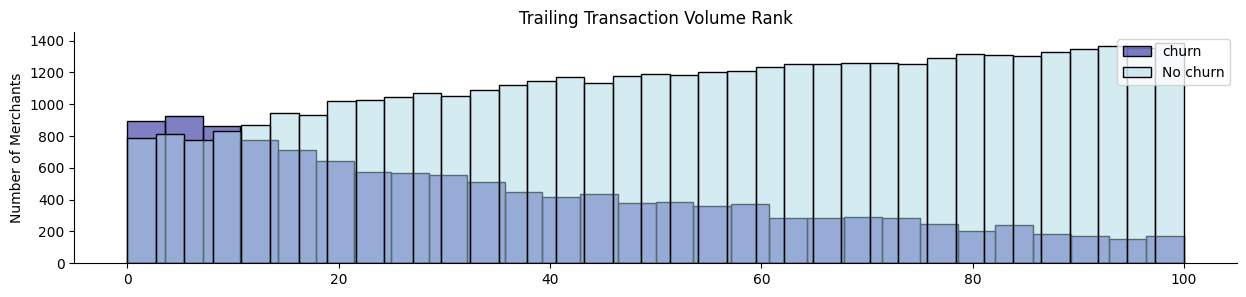

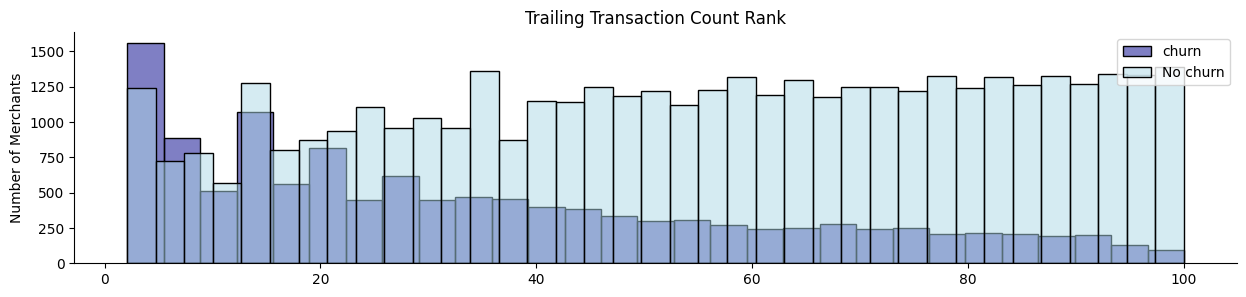

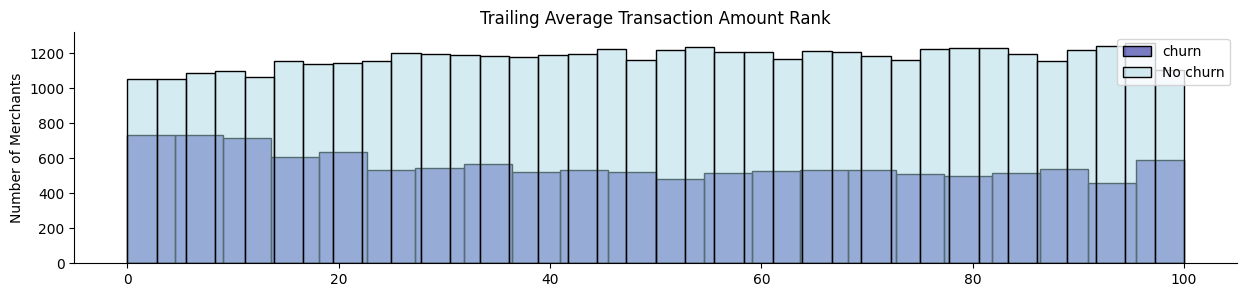

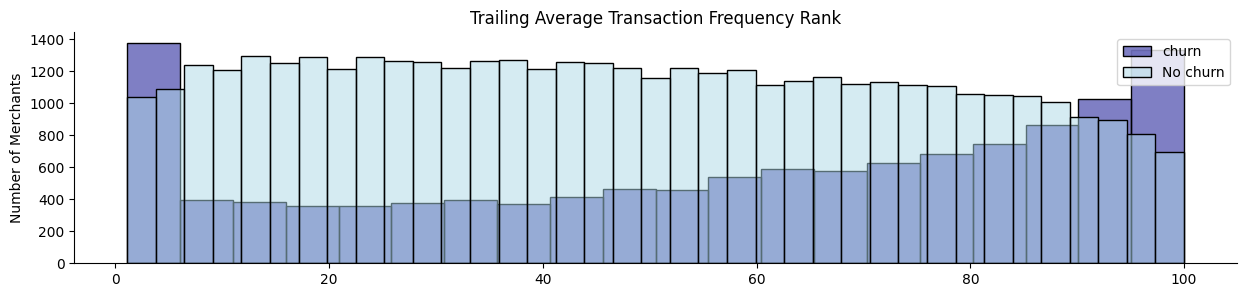

In [28]:
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'trailing_total_tx_volume_rank', 'churn', 'Trailing Transaction Volume Rank', '', 'Number of Merchants')
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'trailing_tx_count_rank', 'churn', 'Trailing Transaction Count Rank', '', 'Number of Merchants')
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'trailing_avg_tx_amount_rank', 'churn', 'Trailing Average Transaction Amount Rank', '', 'Number of Merchants')
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'trailing_avg_tx_freq_rank', 'churn', 'Trailing Average Transaction Frequency Rank', '', 'Number of Merchants')

The trends we observed for the current period are more pronounced for the trailing period

In [30]:
features_of_interest.append(['trailing_total_tx_volume', 'trailing_tx_count', 't_avg_tx_amount', 'trailing_avg_tx_freq', 
                             'trailing_total_tx_volume_rank', 'trailing_tx_count_rank',
                             'trailing_avg_tx_amount_rank', 'trailing_avg_tx_freq_rank'])

### Change

#### Previous Periods

In [31]:
prev_period_change = fe.get_change_prev_periods(mm_all_periods, base_aggregate_cols, 1)
prev_period_change_2 = fe.get_change_prev_periods(mm_all_periods, base_aggregate_cols, 2)
dataset = dataset.merge(prev_period_change, on=['merchant', 'period'])
dataset = dataset.merge(prev_period_change_2, on=['merchant', 'period'])
dataset.shape

(71540, 102)

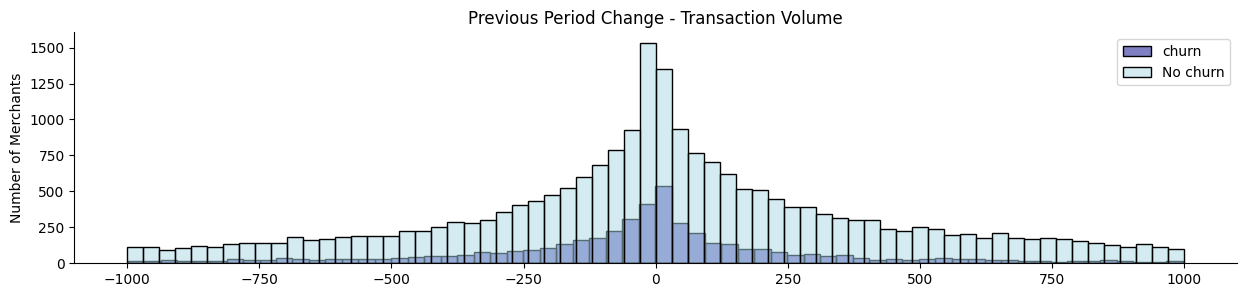

In [32]:
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_1_absdiff_total_tx_volume', 'churn', 'Previous Period Change - Transaction Volume', '', 'Number of Merchants', cutoff=1000)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_1_absdiff_tx_count', 'churn', 'Previous Period Change - Transaction Count', '', 'Number of Merchants', cutoff=20)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_1_absdiff_avg_tx_amount', 'churn', 'Previous Period Change - Average Transaction Amount', '', 'Number of Merchants', cutoff=250)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_1_absdiff_avg_tx_freq', 'churn', 'Previous Period Change - Average Transaction Frequency', '', 'Number of Merchants', cutoff=20)

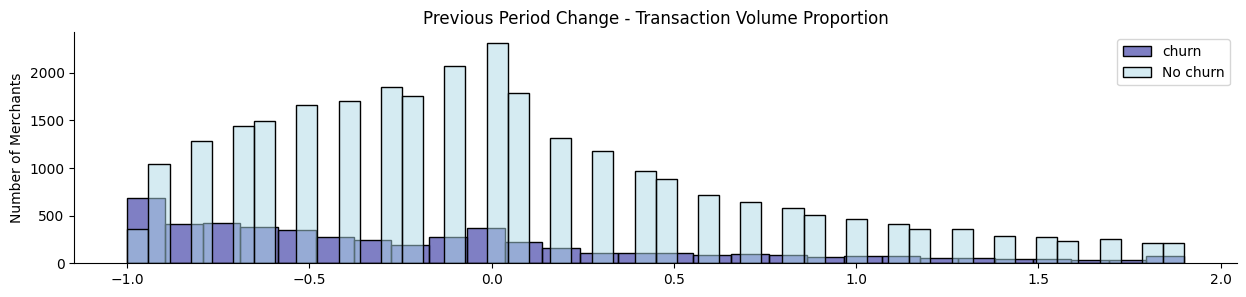

In [33]:
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_1_propch_total_tx_volume', 'churn', 'Previous Period Change - Transaction Volume Proportion', '', 'Number of Merchants', cutoff=2)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_1_propch_tx_count', 'churn', 'Previous Period Change - Transaction Count Proportion', '', 'Number of Merchants', cutoff=2)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_1_propch_avg_tx_amount', 'churn', 'Previous Period Change - Average Transaction Amount Proportion', '', 'Number of Merchants', cutoff=2)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_1_propch_avg_tx_freq', 'churn', 'Previous Period Change - Average Transaction Frequency Proportion', '', 'Number of Merchants', cutoff=2)

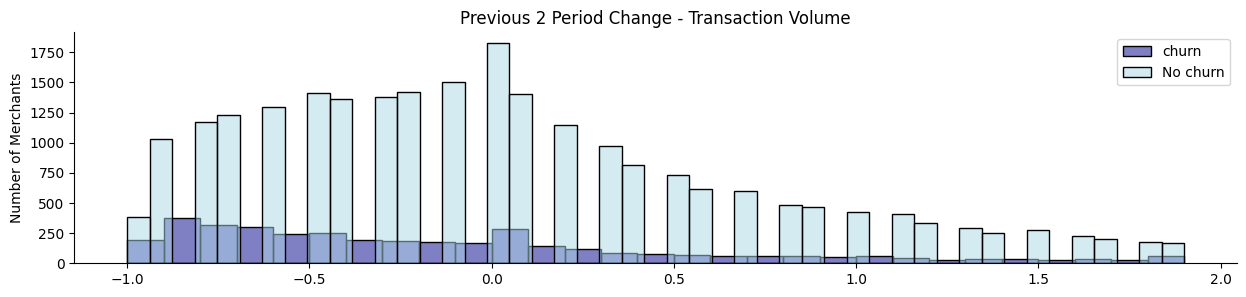

In [34]:
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_2_propch_total_tx_volume', 'churn', 'Previous 2 Period Change - Transaction Volume', '', 'Number of Merchants', cutoff=2)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_2_propch_tx_count', 'churn', 'Previous 2 Period Change - Transaction Count', '', 'Number of Merchants', cutoff=2)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_2_propch_avg_tx_amount', 'churn', 'Previous 2 Period Change - Average Transaction Amount', '', 'Number of Merchants', cutoff=2)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_2_propch_avg_tx_freq', 'churn', 'Previous 2 Period Change - Average Transaction Frequency', '', 'Number of Merchants', cutoff=2)

The change from previous periods does seem to have a bearing on churn - things are easier to see with proportions, so we'll add those to the features of interest

In [35]:
features_of_interest.append(['p_1_propch_total_tx_volume', 'p_2_propch_total_tx_volume'])

#### 3 Months

In [36]:
days = 90
period_duration = round((dataset['period'].dt.end_time - dataset['period'].dt.start_time).dt.total_seconds() / (3600 * 24), 1)
period_duration = np.median(period_duration.unique())
num_periods = int(days / period_duration)

In [37]:
three_month_change = fe.get_change_prev_periods(mm_all_periods, base_aggregate_cols, num_periods)
dataset = dataset.merge(three_month_change, on=['merchant', 'period'])
dataset.shape

(71540, 126)

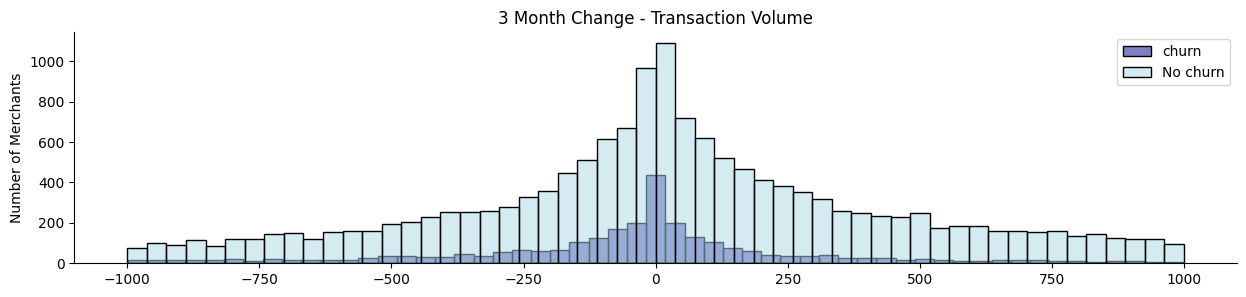

In [38]:
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_3_absdiff_total_tx_volume', 'churn', '3 Month Change - Transaction Volume', '', 'Number of Merchants', cutoff=1000)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_3_absdiff_tx_count', 'churn', '3 Month Change - Transaction Count', '', 'Number of Merchants', cutoff=20)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_3_absdiff_avg_tx_amount', 'churn', '3 Month Change - Average Transaction Amount', '', 'Number of Merchants', cutoff=250)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_3_absdiff_avg_tx_freq', 'churn', '3 Month Change - Average Transaction Frequency', '', 'Number of Merchants', cutoff=20)

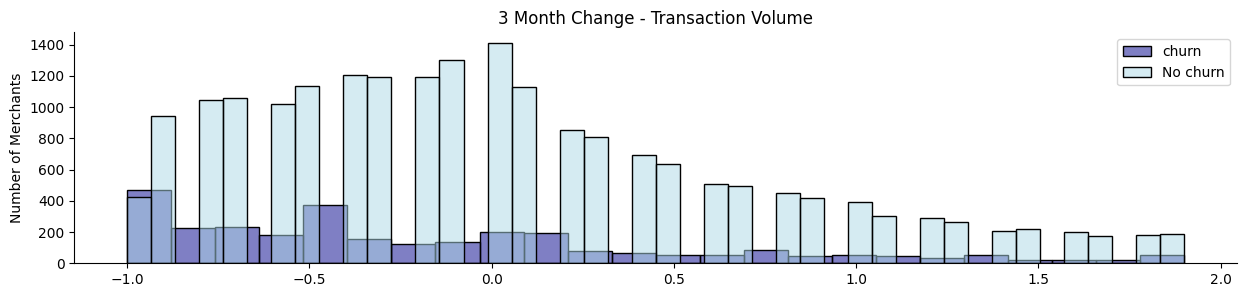

In [39]:
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_3_propch_total_tx_volume', 'churn', '3 Month Change - Transaction Volume', '', 'Number of Merchants', cutoff=2)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_3_propch_tx_count', 'churn', '3 Month Change - Trailing Transaction Count', '', 'Number of Merchants', cutoff=2)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_3_propch_avg_tx_amount', 'churn', '3 Month Change - Trailing Average Transaction Amount', '', 'Number of Merchants', cutoff=2)
# compare_dist(dadataset[dataset['period'].dt.end_time < data_end_cutoff]taset, 'p_3_propch_avg_tx_freq', 'churn', '3 Month Change - Trailing Average Transaction Frequency', '', 'Number of Merchants', cutoff=2)

In [40]:
features_of_interest.append(['p_3_propch_total_tx_volume'])

#### 6 Months

In [41]:
days = 180
period_duration = round((dataset['period'].dt.end_time - dataset['period'].dt.start_time).dt.total_seconds() / (3600 * 24), 1)
period_duration = np.median(period_duration.unique())
num_periods = int(days / period_duration)

In [42]:
six_month_change = fe.get_change_prev_periods(mm_all_periods, base_aggregate_cols, num_periods)
dataset = dataset.merge(six_month_change, on=['merchant', 'period'])
dataset.shape

(71540, 150)

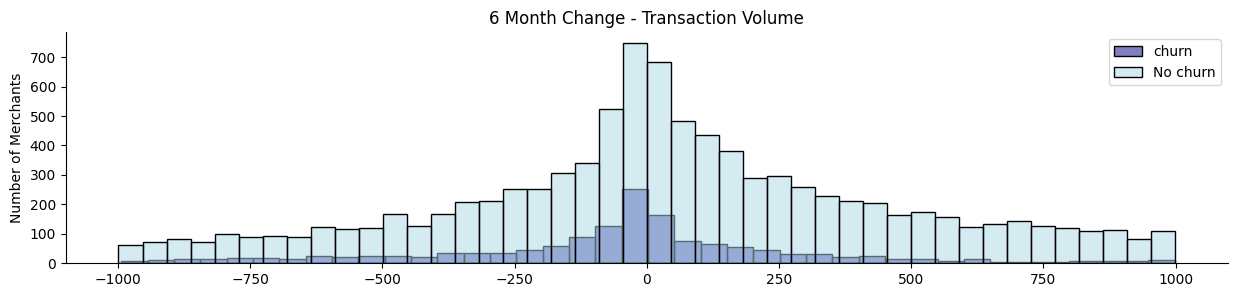

In [43]:
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_6_absdiff_total_tx_volume', 'churn', '6 Month Change - Transaction Volume', '', 'Number of Merchants', cutoff=1000)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_6_absdiff_tx_count', 'churn', '6 Month Change - Transaction Count', '', 'Number of Merchants', cutoff=20)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_6_absdiff_avg_tx_amount', 'churn', '6 Month Change - Average Transaction Amount', '', 'Number of Merchants', cutoff=250)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_6_absdiff_avg_tx_freq', 'churn', '6 Month Change - Average Transaction Frequency', '', 'Number of Merchants', cutoff=20)

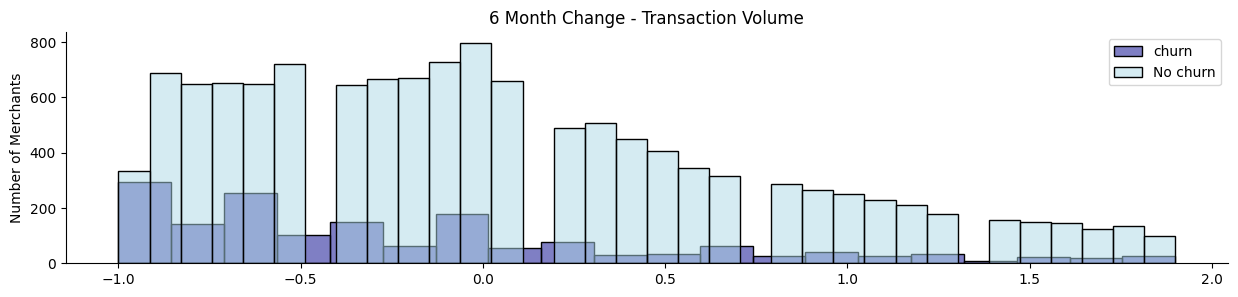

In [44]:
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_6_propch_total_tx_volume', 'churn', '6 Month Change - Transaction Volume', '', 'Number of Merchants', cutoff=2)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_6_propch_tx_count', 'churn', '6 Month Change - Transaction Count', '', 'Number of Merchants', cutoff=2)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_6_propch_avg_tx_amount', 'churn', '6 Month Change - Average Transaction Amount', '', 'Number of Merchants', cutoff=2)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_6_propch_avg_tx_freq', 'churn', '6 Month Change - Average Transaction Frequency', '', 'Number of Merchants', cutoff=2)

In [45]:
features_of_interest.append(['p_6_propch_total_tx_volume'])

#### Ranks

In [46]:
period_change_cols = [c for c in dataset.columns if 'p_' in c]
dataset = fe.assign_rank(dataset, period_change_cols, 'period')
print(dataset.shape)
dataset.head()

(71540, 247)


merchant   period   lfp_start  churn  merchant_age  merchant_age_rank  \
0  0002b63b92  2033-05  2033-06-01      1          15.2                2.0   
1  0002d07bba  2034-10  2034-11-01      0          20.3                3.1   
2  0002d07bba  2034-11  2034-12-01      1          50.3               11.6   
3  0002d07bba  2034-12  2035-01-01      1          81.3               18.2   
4  00057d4302  2033-08  2033-09-01      1          93.9               51.7   

   total_tx_volume  tx_count  avg_tx_amount  median_tx_amount  std_tx_amount  \
0            33.79         1      33.790000            33.790      -1.000000   
1           433.79         2     216.895000           216.895     228.261140   
2           438.42         1     438.420000           438.420      -1.000000   
3            20.57         1      20.570000            20.570      -1.000000   
4            91.35        11       8.304545             7.680       1.607597   

   min_tx_amount  max_tx_amount  avg_tx_freq  median_tx_freq  std_tx_freq  \
0          33.79          33.79    -1.000000           -1.00    -1.000000   
1          55.49         378.30     6.040000            6.04    -1.000000   
2         438.42         438.42    26.910000           26.91    -1.000000   
3          20.57          20.57    31.760000           31.76    -1.000000   
4           7.42          12.48     5.999091            0.01    19.850304   

   min_tx_freq  max_tx_freq  total_tx_volume_rank  tx_count_rank  \
0        -1.00        -1.00                   4.9           13.6   
1         6.04         6.04                  40.8           32.1   
2        26.91        26.91                  39.8           11.3   
3        31.76        31.76                   2.2           12.3   
4         0.00        65.85                  16.7           76.1   

   avg_tx_amount_rank  median_tx_amount_rank  std_tx_amount_rank  \
0                13.4                   16.2                13.6   
1                70.8                   75.1                86.0   
2                83.4                   86.0                11.3   
3                 4.6                    5.8                12.3   
4                 1.2                    1.5                31.1   

   min_tx_amount_rank  max_tx_amount_rank  avg_tx_freq_rank  \
0                38.3                 8.9               4.3   
1                56.8                66.6              49.3   
2                90.4                69.2              80.3   
3                26.1                 3.5              85.2   
4                 6.2                 2.4              50.3   

   median_tx_freq_rank  std_tx_freq_rank  min_tx_freq_rank  max_tx_freq_rank  \
0                  4.3              15.4               4.3               4.3   
1                 55.4              13.5              68.5              24.0   
2                 81.6              12.0              84.7              70.4   
3                 86.1              12.9              88.3              79.7   
4                  7.3              94.0              13.2              92.6   

   trailing_total_tx_volume  trailing_tx_count  trailing_avg_tx_amount  \
0                     33.79                1.0               33.790000   
1                    433.79                2.0              216.895000   
2                    872.21                3.0              327.657500   
3                    892.78                4.0              225.295000   
4                     91.35               11.0                8.304545   

   trailing_median_tx_amount  trailing_std_tx_amount  trailing_min_tx_amount  \
0                    33.7900               -1.000000               33.790000   
1                   216.8950              228.261140               55.490000   
2                   327.6575              113.630570              246.955000   
3                   225.2950               75.420380              171.493333   
4                     7.6800                1.607597                7

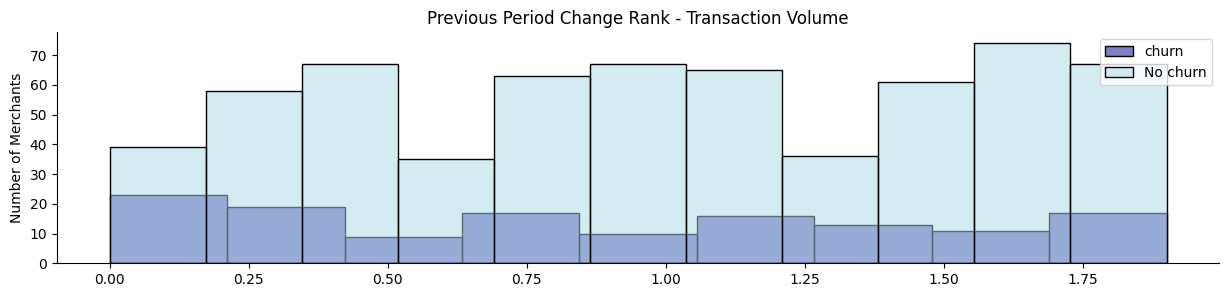

In [47]:
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_1_absdiff_total_tx_volume_rank', 'churn', 'Previous Period Change Rank - Transaction Volume', '', 'Number of Merchants', cutoff=2)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_1_absdiff_tx_count_rank', 'churn', 'Previous Period Change Rank - Transaction Count', '', 'Number of Merchants', cutoff=2)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_1_absdiff_avg_tx_amount_rank', 'churn', 'Previous Period Change Rank - Average Transaction Amount', '', 'Number of Merchants', cutoff=2)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_1_absdiff_avg_tx_freq_rank', 'churn', 'Previous Period Change Rank - Average Transaction Frequency', '', 'Number of Merchants', cutoff=2)

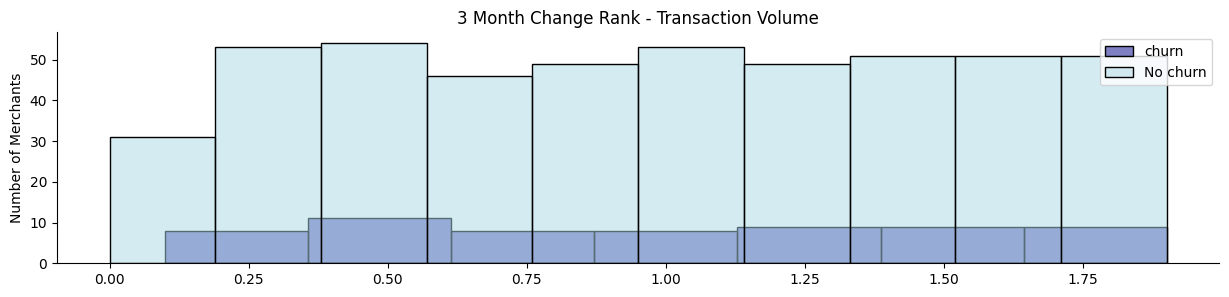

In [48]:
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_3_absdiff_total_tx_volume_rank', 'churn', '3 Month Change Rank - Transaction Volume', '', 'Number of Merchants', cutoff=2)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_3_absdiff_tx_count_rank', 'churn', '3 Month Change Rank - Transaction Count', '', 'Number of Merchants', cutoff=2)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_3_absdiff_avg_tx_amount_rank', 'churn', '3 Month Change Rank - Average Transaction Amount', '', 'Number of Merchants', cutoff=2)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_3_absdiff_avg_tx_freq_rank', 'churn', '3 Month Change Rank - Average Transaction Frequency', '', 'Number of Merchants', cutoff=2)

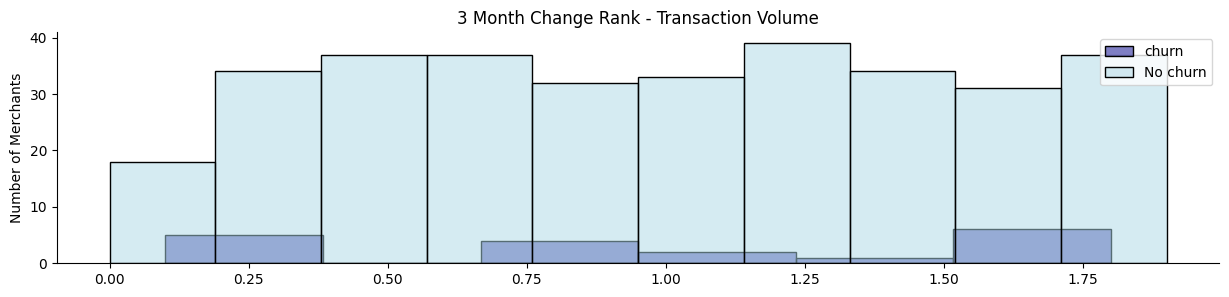

In [49]:
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_6_absdiff_total_tx_volume_rank', 'churn', '3 Month Change Rank - Transaction Volume', '', 'Number of Merchants', cutoff=2)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_6_absdiff_tx_count_rank', 'churn', '3 Month Change Rank - Transaction Count', '', 'Number of Merchants', cutoff=2)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_6_absdiff_avg_tx_amount_rank', 'churn', '3 Month Change Rank - Average Transaction Amount', '', 'Number of Merchants', cutoff=2)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'p_6_absdiff_avg_tx_freq_rank', 'churn', '3 Month Change Rank - Average Transaction Frequency', '', 'Number of Merchants', cutoff=2)

Things aren't very obvious with the ranks, so we'll leave them out of features of interest

#### Peak

In [50]:
peak_change = fe.get_change_peak(merchant_metrics, base_aggregate_cols)
dataset = dataset.merge(peak_change, on=['merchant', 'period'])
dataset.shape

(71540, 271)

In [51]:
peak_change_cols = [c for c in dataset.columns if 'peak_' in c]
dataset = fe.assign_rank(dataset, peak_change_cols, 'period')
print(dataset.shape)
dataset.head()

(71540, 295)


merchant   period   lfp_start  churn  merchant_age  merchant_age_rank  \
0  0002b63b92  2033-05  2033-06-01      1          15.2                2.0   
1  0002d07bba  2034-10  2034-11-01      0          20.3                3.1   
2  0002d07bba  2034-11  2034-12-01      1          50.3               11.6   
3  0002d07bba  2034-12  2035-01-01      1          81.3               18.2   
4  00057d4302  2033-08  2033-09-01      1          93.9               51.7   

   total_tx_volume  tx_count  avg_tx_amount  median_tx_amount  std_tx_amount  \
0            33.79         1      33.790000            33.790      -1.000000   
1           433.79         2     216.895000           216.895     228.261140   
2           438.42         1     438.420000           438.420      -1.000000   
3            20.57         1      20.570000            20.570      -1.000000   
4            91.35        11       8.304545             7.680       1.607597   

   min_tx_amount  max_tx_amount  avg_tx_freq  median_tx_freq  std_tx_freq  \
0          33.79          33.79    -1.000000           -1.00    -1.000000   
1          55.49         378.30     6.040000            6.04    -1.000000   
2         438.42         438.42    26.910000           26.91    -1.000000   
3          20.57          20.57    31.760000           31.76    -1.000000   
4           7.42          12.48     5.999091            0.01    19.850304   

   min_tx_freq  max_tx_freq  total_tx_volume_rank  tx_count_rank  \
0        -1.00        -1.00                   4.9           13.6   
1         6.04         6.04                  40.8           32.1   
2        26.91        26.91                  39.8           11.3   
3        31.76        31.76                   2.2           12.3   
4         0.00        65.85                  16.7           76.1   

   avg_tx_amount_rank  median_tx_amount_rank  std_tx_amount_rank  \
0                13.4                   16.2                13.6   
1                70.8                   75.1                86.0   
2                83.4                   86.0                11.3   
3                 4.6                    5.8                12.3   
4                 1.2                    1.5                31.1   

   min_tx_amount_rank  max_tx_amount_rank  avg_tx_freq_rank  \
0                38.3                 8.9               4.3   
1                56.8                66.6              49.3   
2                90.4                69.2              80.3   
3                26.1                 3.5              85.2   
4                 6.2                 2.4              50.3   

   median_tx_freq_rank  std_tx_freq_rank  min_tx_freq_rank  max_tx_freq_rank  \
0                  4.3              15.4               4.3               4.3   
1                 55.4              13.5              68.5              24.0   
2                 81.6              12.0              84.7              70.4   
3                 86.1              12.9              88.3              79.7   
4                  7.3              94.0              13.2              92.6   

   trailing_total_tx_volume  trailing_tx_count  trailing_avg_tx_amount  \
0                     33.79                1.0               33.790000   
1                    433.79                2.0              216.895000   
2                    872.21                3.0              327.657500   
3                    892.78                4.0              225.295000   
4                     91.35               11.0                8.304545   

   trailing_median_tx_amount  trailing_std_tx_amount  trailing_min_tx_amount  \
0                    33.7900               -1.000000               33.790000   
1                   216.8950              228.261140               55.490000   
2                   327.6575              113.630570              246.955000   
3                   225.2950               75.420380              171.493333   
4                     7.6800                1.607597                7

In [52]:
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'peak_absdiff_total_tx_volume', 'churn', 'Peak Period Change - Transaction Volume', '', 'Number of Merchants', cutoff=200)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'peak_absdiff_tx_count', 'churn', 'Peak Period Change - Transaction Count', '', 'Number of Merchants', cutoff=5)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'peak_absdiff_avg_tx_amount', 'churn', 'Peak Period Change - Average Transaction Amount', '', 'Number of Merchants', cutoff=50)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'peak_absdiff_avg_tx_freq', 'churn', 'Peak Period Change - Average Transaction Frequency', '', 'Number of Merchants', cutoff=5)

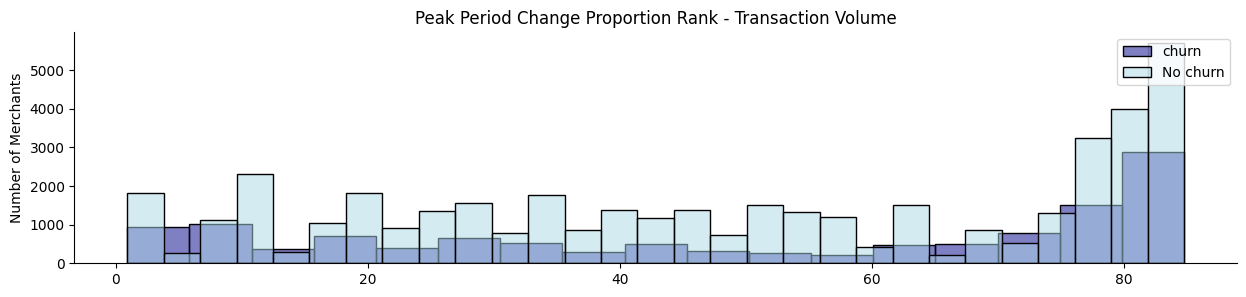

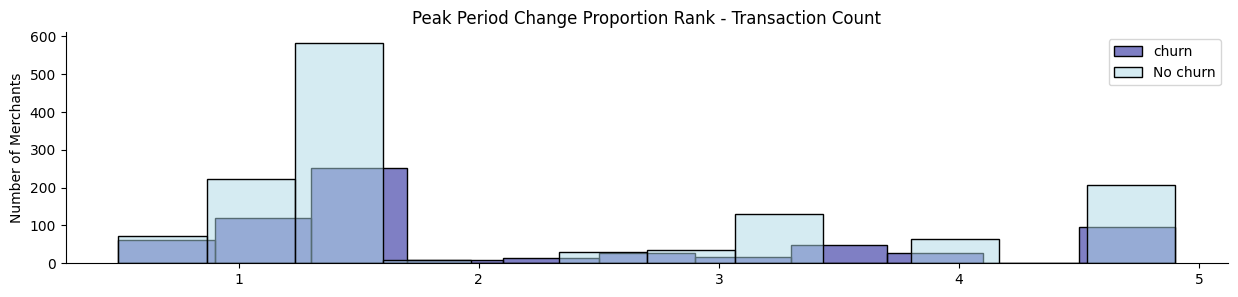

In [53]:
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'peak_prop_total_tx_volume_rank', 'churn', 'Peak Period Change Proportion Rank - Transaction Volume', '', 'Number of Merchants', cutoff=200)
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'peak_prop_tx_count_rank', 'churn', 'Peak Period Change Proportion Rank - Transaction Count', '', 'Number of Merchants', cutoff=5)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'peak_prop_avg_tx_amount_rank', 'churn', 'Peak Period Change Proportion Rank - Average Transaction Amount', '', 'Number of Merchants', cutoff=50)
# compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'peak_prop_avg_tx_freq_rank', 'churn', 'Peak Period Change Proportion Rank - Average Transaction Frequency', '', 'Number of Merchants', cutoff=5)

In [54]:
features_of_interest.append(['peak_prop_total_tx_volume_rank', 'peak_prop_tx_count_rank'])

#### YoY

In [55]:
yoy_change = fe.get_yoy_change(merchant_metrics, PREDICTION_FREQUENCY)
dataset = dataset.merge(yoy_change, on=['merchant', 'period'])
dataset.shape

(71540, 297)

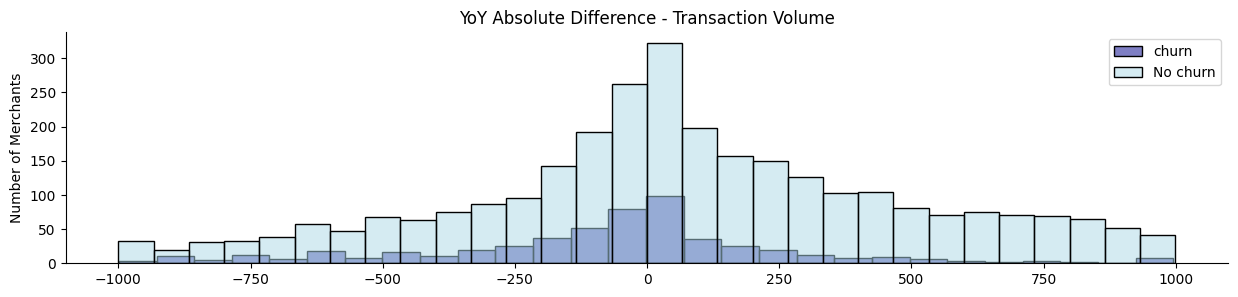

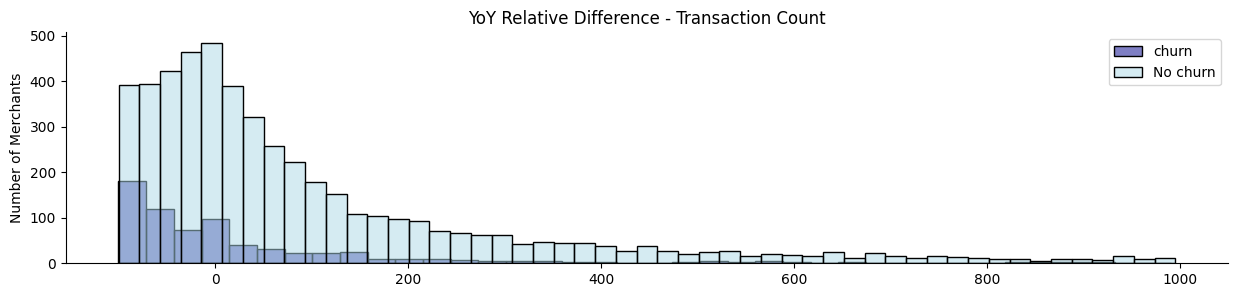

In [56]:
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'yoy_abs_diff', 'churn', 'YoY Absolute Difference - Transaction Volume', '', 'Number of Merchants', cutoff=1000)
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'yoy_pct_diff', 'churn', 'YoY Relative Difference - Transaction Count', '', 'Number of Merchants', cutoff=1000)

In [57]:
features_of_interest.append(['yoy_abs_diff', 'yoy_pct_diff'])

### Historical Max Gap Between Tx

In [58]:
mhtd = fe.get_max_historical_gap_bw_tx(data)
dataset = dataset.merge(mhtd, on=["merchant", "period"])
dataset.shape

(71540, 298)

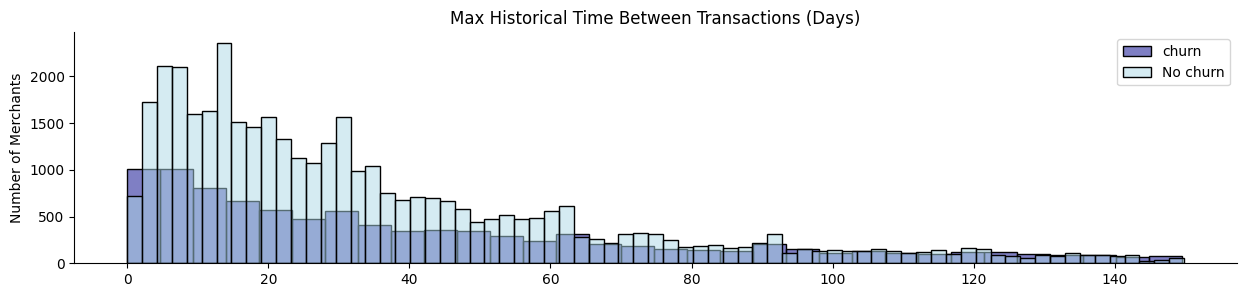

In [59]:
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'max_hist_time_diff', 'churn', 'Max Historical Time Between Transactions (Days)', '', 'Number of Merchants', cutoff=150)

In [60]:
features_of_interest.append(['max_hist_time_diff'])

### Useful Plots for the Presentation

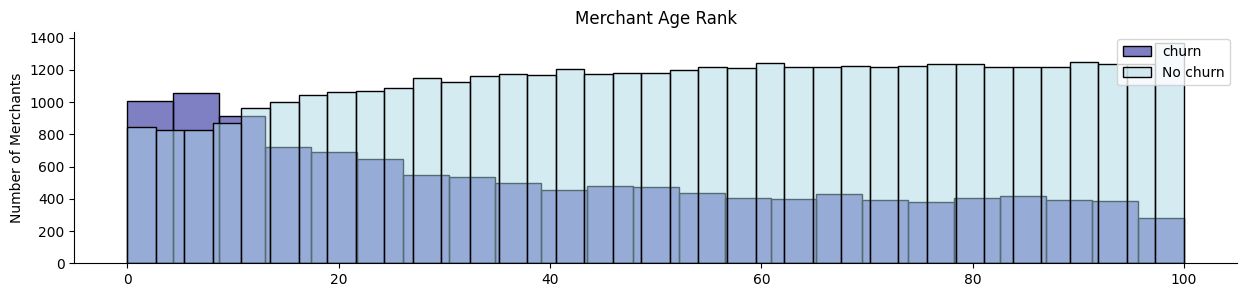

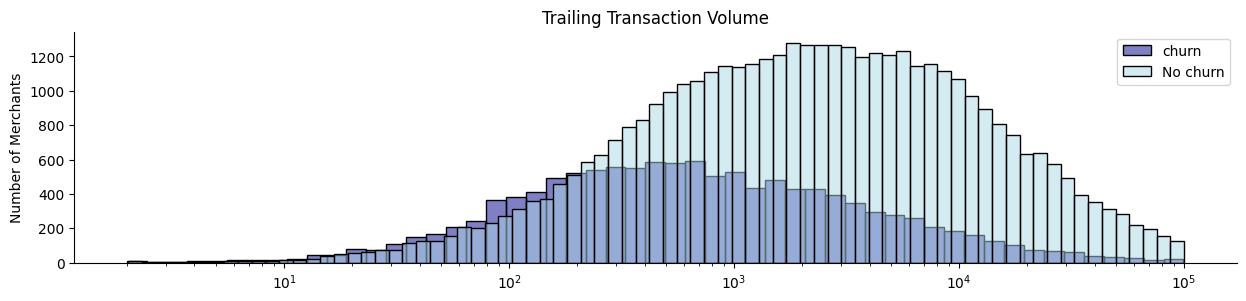

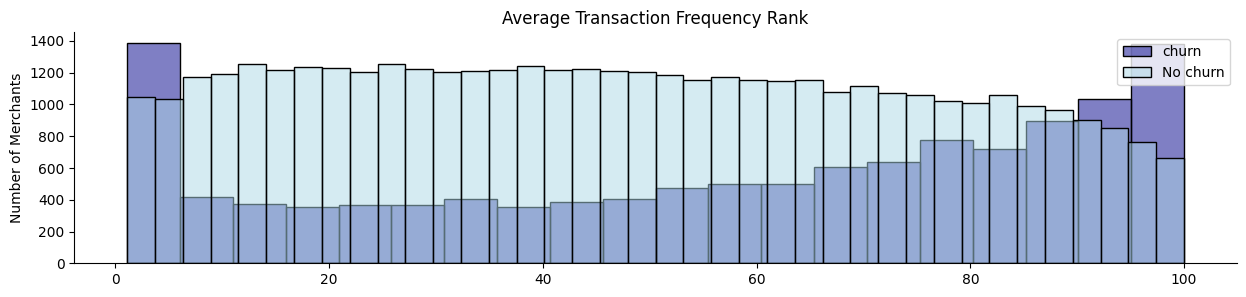

In [62]:
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'merchant_age_rank', 'churn', 'Merchant Age Rank', '', 'Number of Merchants')
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'trailing_total_tx_volume', 'churn', 'Trailing Transaction Volume', '', 'Number of Merchants', cutoff=100000, log_scale=True)
compare_dist(dataset[dataset['period'].dt.end_time < data_end_cutoff], 'avg_tx_freq_rank', 'churn', 'Average Transaction Frequency Rank', '', 'Number of Merchants')

# Modeling

## Baseline

Before jumping into more sophisticated modeling, we'll build a simple baseline - if a merchant is below the 20th percentile in either `merchant_age` or the `trailing_tx_volume` we predict that they'll churn. This performs relatively well, with a precision of `.36` and a recall of `0.57`. Since it's a heuristic however, we can't play with the thresholds to find the right balance of precision and recall for our use case.

In [63]:
bl = dataset[(dataset['period'].dt.end_time < data_end_cutoff) & (dataset['period'].dt.start_time > '2034-07-01')][['merchant', 'period', 'churn', 'merchant_age_rank', 'trailing_total_tx_volume_rank']]
bl['pred'] = np.where((bl['merchant_age_rank'] < 20) | (bl['trailing_total_tx_volume_rank'] < 20), 1, 0)
print(bl['pred'].value_counts())
print(eval_classification(bl['churn'], bl['pred']))

pred
0    6736
1    3147
Name: count, dtype: int64
{'f1': 0.44, 'precision': 0.36, 'recall': 0.57}


## Feature Selection

In [64]:
print(dataset.shape)
features_of_interest = [item for sublist in features_of_interest for item in sublist]
len(features_of_interest)

(71540, 298)


35

Our feature engineering has yielded ~300 features, almost all of them strongly correlated. This a large number of features to have for ~70,000 observations, since there won't be enough data points within each combination of values for the model to truly learn. That said, in practice, we can let the model decide what's important, and reduce the number of features based post an initial round of training. 

Keeping too many features isn't ideal -  the more features we have, the more we have to maintain and monitor in production, the more the computation required, the greater the cost and latency, so we'll try to get that number down significantly for the final model.

Alternatively, we could also just use our features of interest - given how simple this dataset is, and the limits of the data, it's likely this will perform just as well as the more complex, model driven selection. That said, one shouldn't use this approach for more complex modeling tasks where a number of different data sources are available and interactions possible.

After evaluating both, passing in all features is better, though not very significantly so.

## Train - Val - Test Split

We'll split the data into train, val, and test sets - with the val set being used for tuning, and the test set for final evaluation. We'll split based on time to make sure there's no leakage, and that the model can generalize into the future.

The time ranges have been defined in the config above but are repeated here for convenience:

`training`: 2033-06-01 - 2034-05-31

`validation`: 2034-06-01 - 2034-07-31

`test`: 2034-08-01 - 2034-09-30

Given that the platform has grown over time, the number of transactions in the validation and test periods are higher than their proportion of the time period would suggest.

## Model Selection

We'll use XGBoost - it performs best for tabular problems like these. While we could have used a logistic regression instead, that usually doesn't perform as well. Alternatives to XGBoost are LightGBM and CatBoost, but since their performance is similar, XGBoost should be fine for our purposes. 

We'll use the following params to start. These have been derived by peforming a grid search over the data.

In [65]:
params = {
    "objective": "binary:logistic",
    "learning_rate": 0.1,
    "max_depth": 8,
    "subsample":0.8,
    "colsample_bytree":0.4,
    "eval_metric": "logloss"
}

## Metrics

Since our data is imbalanced, we'll use Precision, Recall, and F1 Scores. These scores also give us single measures of the types of mistakes our model is making - whether it's incorrectly predicting that a merchant will churn (precision), or missing merchants who will churn (recall). The F1 score gives us a good balance of the two.

We also have to think about what we value more - do we care about being right if we predict that a merchant will churn, or would we rather capture all merchants who may be at risk, knowing that we'll get it wrong some of the time. For this use case, the latter makes more sense, so we'll try to maximize recall for a given precision floor.

## Fit Predict Evaluate

In [66]:
# cols_to_keep = ['merchant','period', 'lfp_start', 'churn'] + features_of_interest
cols_to_keep = dataset.columns
len(cols_to_keep)

298

In [67]:
dataset = dataset.fillna(-1)
train, val = train_test_split(dataset[cols_to_keep], 'lfp_start', TRAIN_START, VAL_START, TEST_START)
print(f"Train: {train['lfp_start'].min()}, {train['lfp_start'].max()}")
print(f"Val: {val['lfp_start'].min()}, {val['lfp_start'].max()}")
print(train.shape, val.shape)

Train: 2033-06-01, 2034-05-01
Val: 2034-06-01, 2034-07-01
(29440, 298) (8487, 298)


In [68]:
extraneous_cols = ['merchant','period', 'lfp_start', 'churn']
features = train.columns[~train.columns.isin(extraneous_cols)]
X_train, y_train = train[features], train['churn'].values
X_val, y_val = val[features], val['churn'].values
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(29440, 294) (29440,) (8487, 294) (8487,)


In [69]:
dt = xgb.DMatrix(X_train, label=y_train)
dv = xgb.DMatrix(X_val, label=y_val)
mdl = xgb.train(params, dt, 400, [(dt, "train"),(dv, "valid")], early_stopping_rounds=100, verbose_eval=25)
predictions = mdl.predict(dv)

preds = np.where(predictions > 0.5, 1, 0)
print(eval_classification(y_val, preds))

[0]	train-logloss:0.65097	valid-logloss:0.64994
[25]	train-logloss:0.37604	valid-logloss:0.42117
[50]	train-logloss:0.32923	valid-logloss:0.41623
[75]	train-logloss:0.30438	valid-logloss:0.41858
[100]	train-logloss:0.28187	valid-logloss:0.42000
[125]	train-logloss:0.26213	valid-logloss:0.42329
[150]	train-logloss:0.24589	valid-logloss:0.42619
{'f1': 0.38, 'precision': 0.58, 'recall': 0.29}


Let's remove extraneous columns using SHAP

In [70]:
explainer = shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(X_train)
print(shap_values.shape)

(29440, 294)


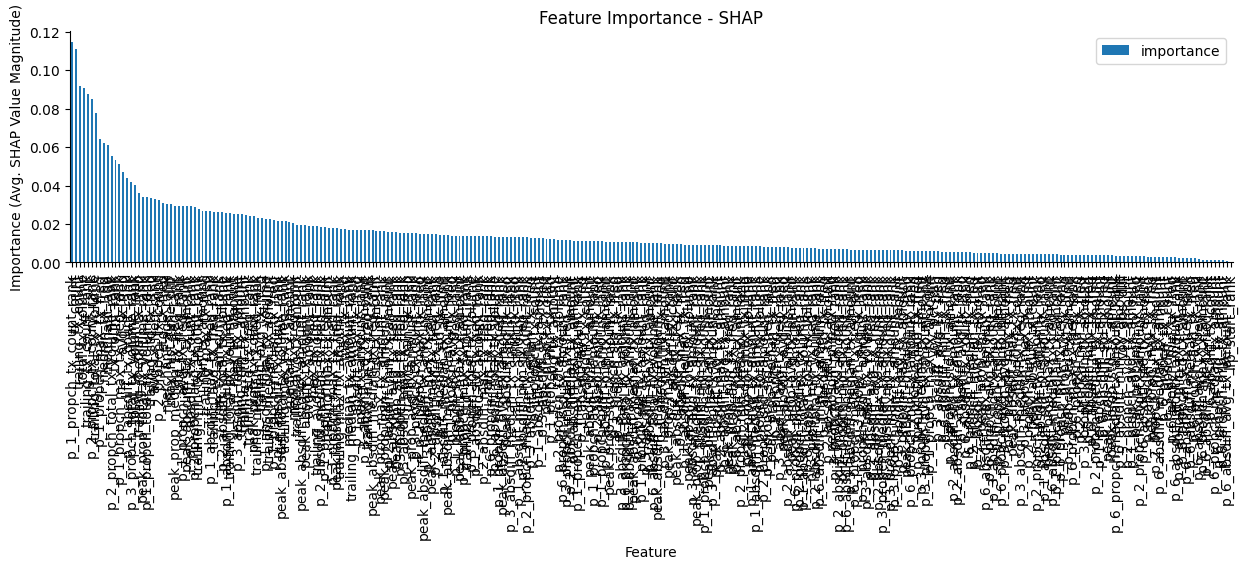

In [71]:
imps = pd.DataFrame(list(zip(X_train.columns,pd.DataFrame(np.abs(shap_values)).mean(axis=0))))
imps.columns = ['feature', 'importance']
imps = imps.sort_values('importance', ascending=False)
imps = imps.set_index(imps['feature'])
imps.plot.bar()
format_plot('Feature Importance - SHAP', 'Feature', 'Importance (Avg. SHAP Value Magnitude)')

Based on the plot and experimentation, we'll keep the top 50, and retrain without a loss in performance

In [72]:
tokeep = imps[:50]['feature'].unique()
X_train = X_train[tokeep]
X_val = X_val[tokeep]
print(X_train.shape, X_val.shape)

dt = xgb.DMatrix(X_train, label=y_train)
dv = xgb.DMatrix(X_val, label=y_val)
mdl = xgb.train(params, dt, 400, [(dt, "train"),(dv, "valid")], early_stopping_rounds=100, verbose_eval=25)
predictions = mdl.predict(dv)

preds = np.where(predictions > 0.5, 1, 0)
print(eval_classification(y_val, preds))

(29440, 50) (8487, 50)
[0]	train-logloss:0.65165	valid-logloss:0.64995
[25]	train-logloss:0.38374	valid-logloss:0.42127
[50]	train-logloss:0.34073	valid-logloss:0.41538
[75]	train-logloss:0.31629	valid-logloss:0.41681
[100]	train-logloss:0.29639	valid-logloss:0.41884
[125]	train-logloss:0.27635	valid-logloss:0.42134
[150]	train-logloss:0.25987	valid-logloss:0.42314
[155]	train-logloss:0.25689	valid-logloss:0.42381
{'f1': 0.38, 'precision': 0.59, 'recall': 0.28}


We get a higher precision than the baseline, but a lower recall. Looking at the distribution of the predictions and the precision recall curve, the model could use some calibration - there's some room to play with the threshold.

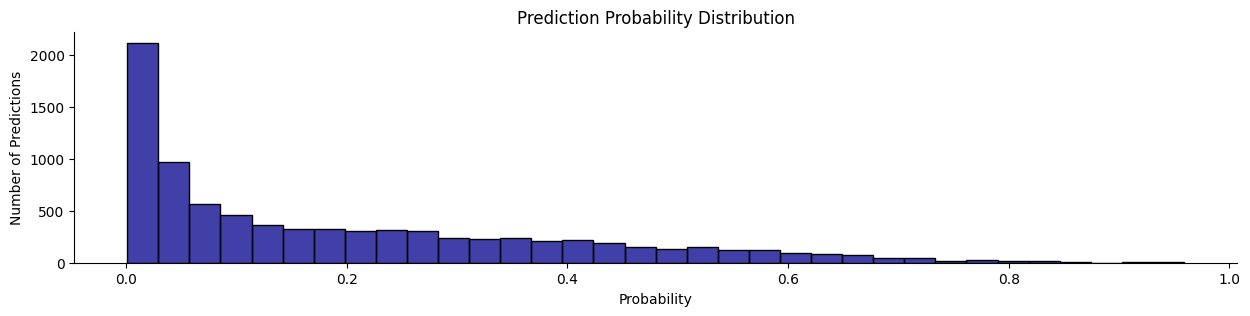

In [73]:
sns.histplot(predictions, color='darkblue')
format_plot("Prediction Probability Distribution", "Probability", "Number of Predictions")

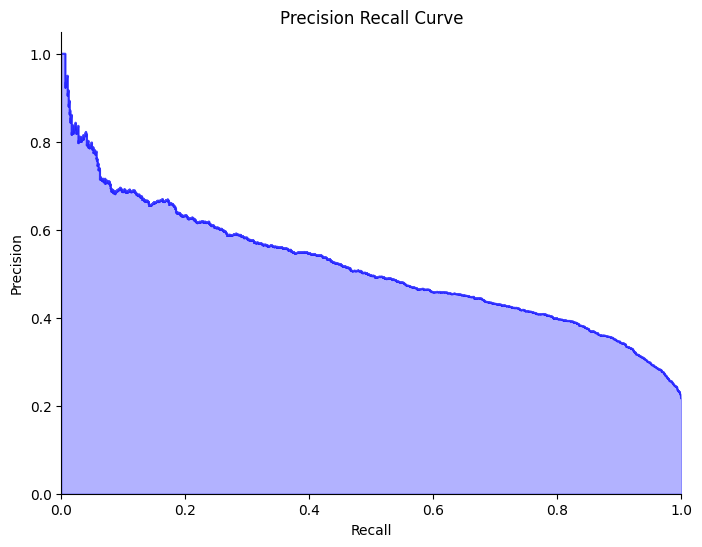

In [74]:
plot_precision_recall_curve(y_val, predictions)

In [75]:
preds = np.where(predictions > 0.35, 1, 0)
print(eval_classification(y_val, preds))

{'f1': 0.5, 'precision': 0.49, 'recall': 0.51}


**At a threshold of .35, half of our predictions are correct, and we're identifying more than half of all merchants who'll churn. This isn't great performance, but not unexpected given that we just have a single, albeit important, dataset to model**

In [76]:
features_to_keep = list(X_train.columns) + extraneous_cols

## Hyperparameter Tuning

This code takes a while to run so is commented out - its output has been incoporated into the params defined above

In [77]:
# base_params = {
#     "objective": "binary:logistic",
#     "n_estimators": 200,
#     "learning_rate": 0.3,
#     "max_depth": 8,
#     "subsample":0.8,
#     "colsample_bytree":0.8,
#     "eval_metric": "logloss"
# }

# param_dist = {'max_depth': [4, 8],
#               'n_estimators':[200, 400],
#               'learning_rate': [0.3, 0.1],
#               'subsample': [0.5, 0.8],
#               'colsample_bytree': [0.4, 0.8],
#               'max_delta_step': [1, 3]}

# mdl = xgb.XGBClassifier(**base_params)
# tscv = TimeSeriesSplit(n_splits=3)
# grid_search = GridSearchCV(mdl, param_grid=param_dist, cv=tscv, scoring='f1', 
#                                    verbose=10, n_jobs=-1)

# grid_search.fit(X_train, y_train)
# grid_search.best_params_

## Test Set Evaluation

Given that the platform is evolving, we'll retrain the model up to the most recent point, using the params identified by using the validation set

In [78]:
train, test = train_test_split(dataset[features_to_keep], 'lfp_start', TRAIN_START, TEST_START, TEST_END)
# print(train['lfp_start'].min(), train['lfp_start'].max())
# print(test['lfp_start'].min(), test['lfp_start'].max())
# print(train.shape, test.shape)

features = train.columns[~train.columns.isin(extraneous_cols)]
X_train, y_train = train[features], train['churn'].values
X_test, y_test = test[features], test['churn'].values
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

dt = xgb.DMatrix(X_train, label=y_train)
dv = xgb.DMatrix(X_test, label=y_test)
mdl = xgb.train(params, dt, 400, [(dt, "train"),(dv, "valid")], early_stopping_rounds=100, verbose_eval=25)
predictions = mdl.predict(dv)

preds = np.where(predictions > 0.5, 1, 0)
print(eval_classification(y_test, preds))

(37927, 50) (37927,) (9366, 50) (9366,)
[0]	train-logloss:0.65078	valid-logloss:0.64809
[25]	train-logloss:0.38635	valid-logloss:0.40152
[50]	train-logloss:0.34570	valid-logloss:0.39201
[75]	train-logloss:0.32497	valid-logloss:0.39275
[100]	train-logloss:0.30724	valid-logloss:0.39372
[125]	train-logloss:0.28953	valid-logloss:0.39538
[150]	train-logloss:0.27351	valid-logloss:0.39652
{'f1': 0.38, 'precision': 0.52, 'recall': 0.29}


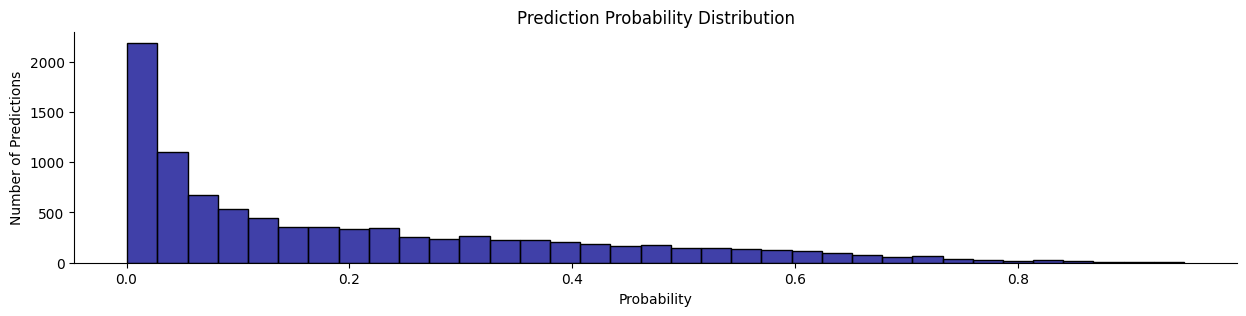

In [79]:
sns.histplot(predictions, color='darkblue')
format_plot("Prediction Probability Distribution", "Probability", "Number of Predictions")

In [80]:
preds = np.where(predictions > 0.35, 1, 0)
print(eval_classification(y_test, preds))

{'f1': 0.5, 'precision': 0.47, 'recall': 0.53}


The performance holds on the test set - this indicates that as long as we retrain the model frequently, we should expect fairly consistent performance

## Final Model Training

Let's train the model on all the labelled data we have (up to `2034-09-30`) and use it to make predictions about merchants active in the last three months

In [81]:
train = dataset[(pd.to_datetime(dataset['lfp_start']) >= TRAIN_START) & ((pd.to_datetime(dataset['lfp_start']) <= "2034-10-01"))]
train = train[features_to_keep]
print(f"Train: {train['lfp_start'].min()}, {train['lfp_start'].max()}")
print(train.shape)

features = train.columns[~train.columns.isin(extraneous_cols)]
X_train, y_train = train[features], train['churn'].values
print(X_train.shape, y_train.shape)

dt = xgb.DMatrix(X_train, label=y_train)
mdl_final = xgb.train(params, dt, 400)

Train: 2033-06-01, 2034-10-01
(52295, 54)
(52295, 50) (52295,)


## Inference

In [82]:
to_predict = dataset[pd.to_datetime(dataset['lfp_start']) >= "2034-11-01"][features_to_keep]
print(to_predict['lfp_start'].min(), to_predict['lfp_start'].max())
print(to_predict.shape)

features = to_predict.columns[~to_predict.columns.isin(extraneous_cols)]
X_predict = to_predict[features]
X_predict.shape

2034-11-01 2035-01-01
(16895, 54)


(16895, 50)

In [83]:
dv = xgb.DMatrix(X_predict)
probabilities = mdl_final.predict(dv)

### Sensechecks

16895


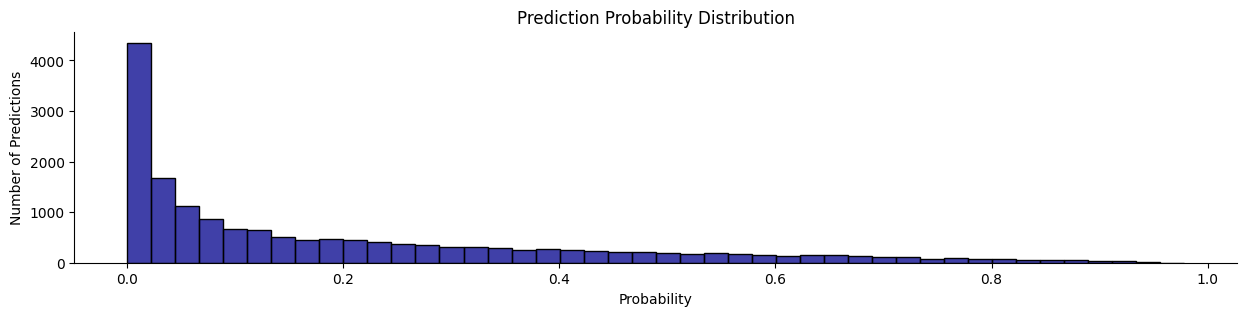

In [84]:
print(len(probabilities))
sns.histplot(probabilities, color='darkblue')
format_plot("Prediction Probability Distribution", "Probability", "Number of Predictions")

In [85]:
to_predict['churn_probability'] = probabilities
to_predict['churn_predicted'] = np.where(to_predict['churn_probability'] > 0.35, 1, 0)

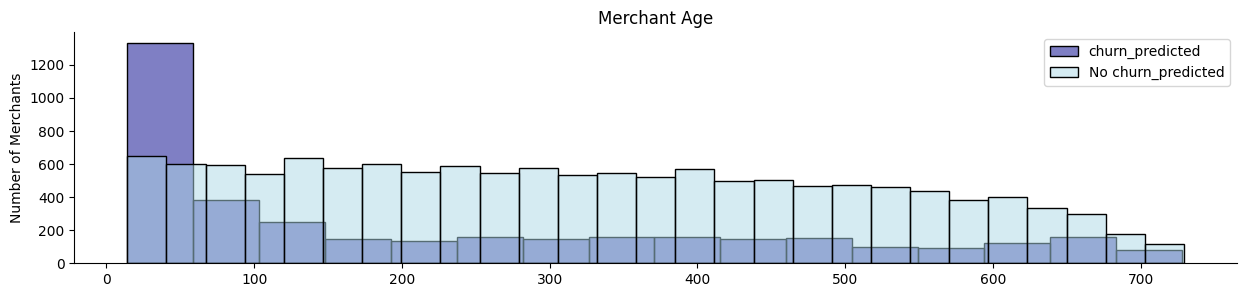

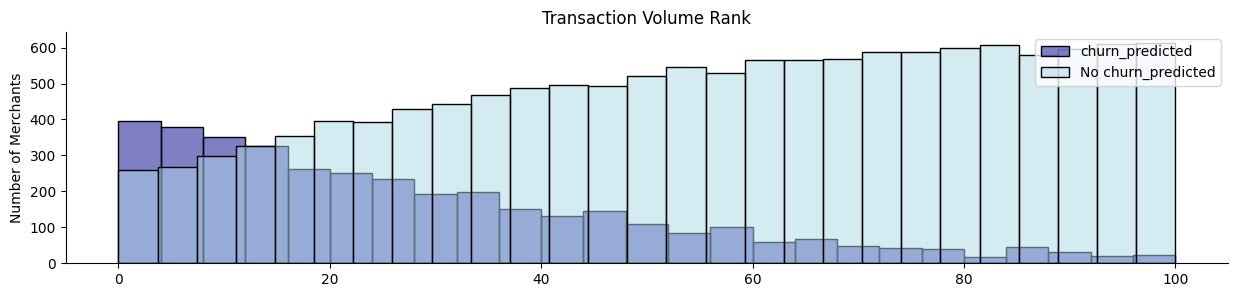

In [86]:
compare_dist(to_predict, 'merchant_age', 'churn_predicted', 'Merchant Age', '', 'Number of Merchants')
compare_dist(to_predict, 'total_tx_volume_rank', 'churn_predicted', 'Transaction Volume Rank', '', 'Number of Merchants')

In [87]:
to_predict_sorted = to_predict.sort_values(by=['merchant', 'period'], ascending=[True, False])
latest_predictions = to_predict_sorted.drop_duplicates(subset='merchant', keep='first')[['merchant', 'period', 'churn_predicted', 'churn_probability']]
latest_predictions['churn_probability'] = round(latest_predictions['churn_probability'], 2)
latest_predictions.head()

merchant   period  churn_predicted  churn_probability
3   0002d07bba  2034-12                1               0.42
25  000ed1585f  2034-12                1               0.49
40  000f8c3297  2034-12                0               0.01
57  002a66c0e1  2034-12                0               0.02
66  003d24c5d3  2034-12                0               0.30

In [88]:
print(f"{len(latest_predictions[latest_predictions['churn_predicted'] == 1])} merchants active since 2034-10-01 are at risk of churn over the next 3 months")

2465 merchants active since 2034-10-01 are at risk of churn over the next 3 months


## Write

In [96]:
# latest_predictions.to_csv(OUT_DIR + OUT_FILE, index=False)

# Interpretability

Instead of using classical feature importance techniques such as weight/cover, gain, and feature permutation, all of which have different [limitations](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27), we'll use an approach called [Shapley Additive Explanation Values (SHAP)](https://github.com/slundberg/shap). SHAP ensures stable, consistent results, and accounts for feature importance in a more robust manner. This [blog post](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27) provides an excellent overview, and the details can be found in this [paper](https://arxiv.org/pdf/1802.03888.pdf). 

It should be noted that SHAP values are just indicators, they shouldn't be used as precise explanations for decision making.

In [97]:
explainer = shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(X_train)
print(shap_values.shape)

(52295, 50)


## Global Feature Importance

We see a nice even spread of values contributing to the model - no one feature is far more important than others, indicating that there isn't any leakage.

As expected, merchant age, the number of transactions, transaction volume, and transaction frequency play a strong role. Normalized ranks, and changes from previous periods are also important.

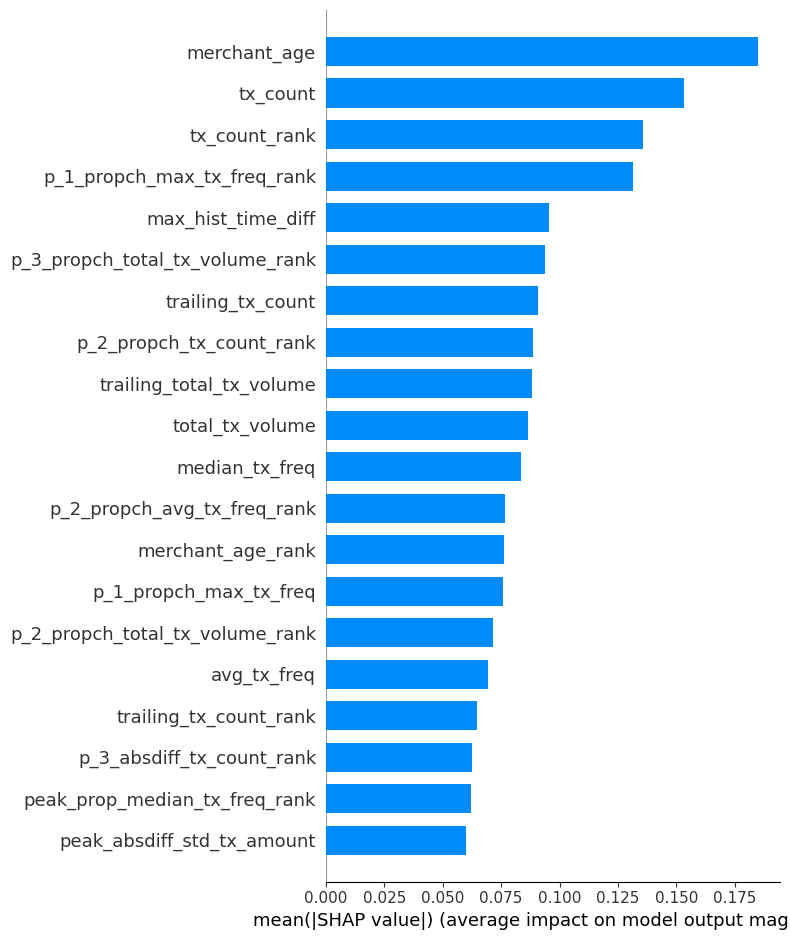

In [98]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=20)

## Density, Dispersion, and Directionality

The plot below shows the directional impact of different values - for instance, the higher the transaction count rank, i.e., the more transactions a merchant has relative to other in the same period, the less likely they are to churn.

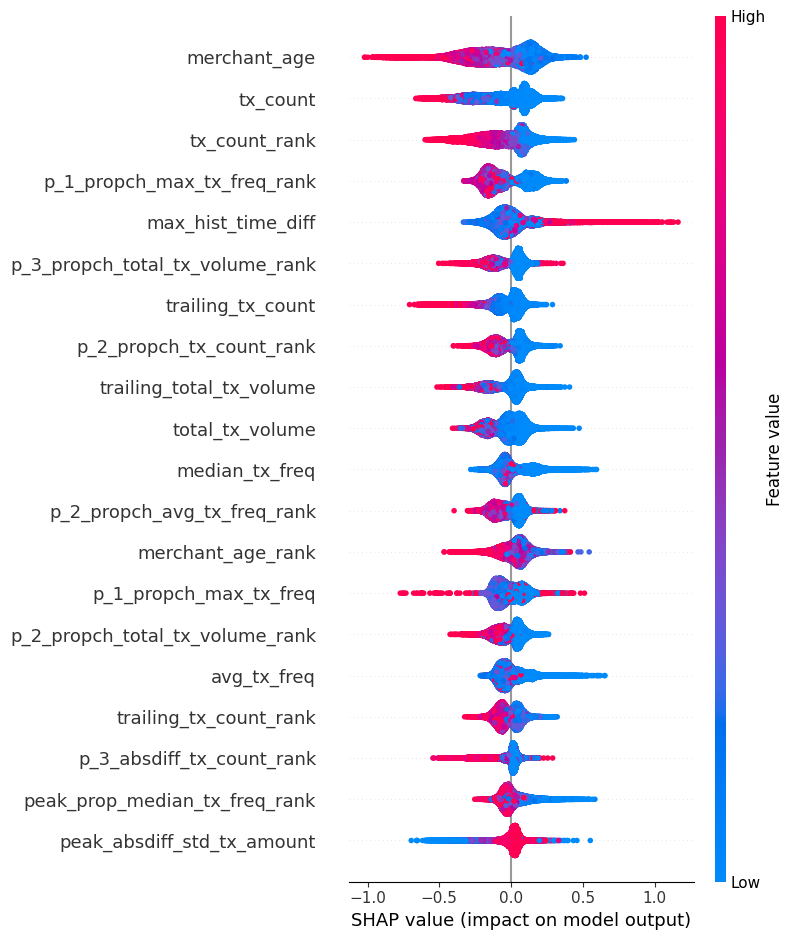

In [99]:
shap.summary_plot(shap_values, X_train, max_display=20)

## Partial Dependence

As a merchant's transaction count rank rises, they're significantly less likely to churn. The older they are, the more likely they are to churn if their tx count rank is low - meaning that an older merchant without a lot of transactions is at higher risk

In [100]:
shap.dependence_plot('tx_count_rank', shap_values, X_train, interaction_index='merchant_age', 
                     title='Partial Dependence - Total Transaction Count Rank', alpha=0.2)

We can see that as merchants start out on the platform, they're more likely to churn, up until about 100 days. From that point on their likelihood of churning steadily reduces

In [101]:
shap.dependence_plot('merchant_age', shap_values, X_train, interaction_index=None, 
                     title='Partial Dependence - Merchant Age', alpha=0.2)

# Error Analysis

In [102]:
probabilities_test = mdl.predict(xgb.DMatrix(X_test))
test['churn_probability'] = probabilities_test
test['churn_predicted'] = np.where(test['churn_probability'] > 0.35, 1, 0)
test['churn_predicted'].value_counts()

churn_predicted
0    7295
1    2071
Name: count, dtype: int64

## Segmentation

In [103]:
test = test.merge(mt, on="merchant")
test['category'].value_counts()

category
Average                                5768
Low Volume                             1569
High Vol: Low Tx Amount + High Freq     858
High Vol: High Tx Amount + Low Freq     485
Very Low Volume                         354
Very High Volume                        236
Single Tx                                94
High End                                  2
Name: count, dtype: int64

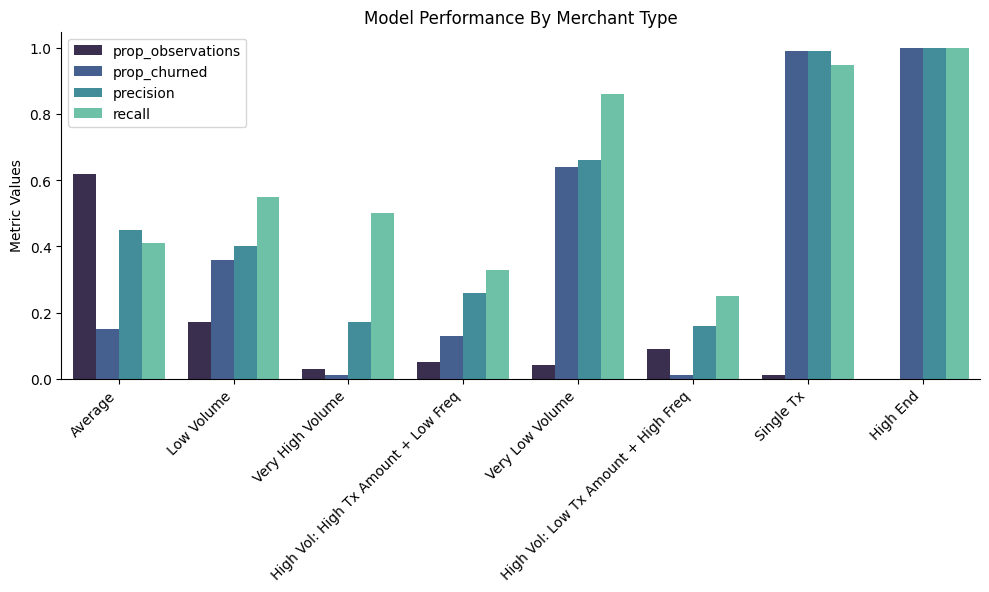

In [106]:
cat_data = {
    "category": [],
    "num_observations": [],
    "num_churned": [],
    "prop_observations": [],
    "prop_churned": [],
    "f1": [],
    "precision": [],
    "recall": []
}

for c in test['category'].unique():
    ss = test[test['category'] == c]
    
    num_obs = len(ss)
    prop_obs = round(num_obs / len(test), 2)
    num_churn = len(ss[ss['churn'] == 1])
    prop_churn = round(num_churn / num_obs, 2)
    
    eval_results = eval_classification(ss['churn'], ss['churn_predicted'])
    
    cat_data["category"].append(c)
    
    cat_data["num_observations"].append(num_obs)
    cat_data["num_churned"].append(num_churn)
    cat_data["prop_observations"].append(prop_obs)
    cat_data["prop_churned"].append(prop_churn)
    cat_data["f1"].append(eval_results["f1"])
    cat_data["precision"].append(eval_results["precision"])
    cat_data["recall"].append(eval_results["recall"])
    
df = pd.DataFrame(cat_data)

plt.figure(figsize=(10, 6))
sns.barplot(data=df[['category', 'prop_observations', 'prop_churned', 'precision', 'recall']].melt(id_vars="category"), x="category", y="value", hue="variable", ci=None, palette="mako")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.legend()
format_plot("Model Performance By Merchant Type", "", "Metric Values")

The model does best on low volume merchants, and somewhat better on average merchants, but it struggles on high volume merchants. This could be for a number of reasons:
- There are far fewer observations of high volume merchants, and even fewer of them churning. It's possible the model doesn't have enough data to learn from, and is overcorrecting with its experiences with low volume merchants. Adding more high volume merchant churn observations should help here
- Given the limited nature of the feature space, low volume merchants are easier to predict churn for. It's likely that high volume merchants churn for reasons other than those available in this dataset - e.g., moving to another platform. Adding additional datasets would help here

## False Positives

In [107]:
test['true_positive'] = np.where((test['churn'] == 1) & (test['churn_predicted'] == 1), 1, 0)
test['true_negative'] = np.where((test['churn'] == 0) & (test['churn_predicted'] == 0), 1, 0)
test['false_positive'] = np.where((test['churn'] == 0) & (test['churn_predicted'] == 1), 1, 0)
test['false_negative'] = np.where((test['churn'] == 1) & (test['churn_predicted'] == 0), 1, 0)
test['correct'] = np.where((test['true_positive'] == 1) | (test['true_negative'] == 1), 1, 0)

False Positives and True positives have very similar patterns, explaining why the precision isn't higher. We need another way of distinguishing these, perhaps more metadata about product category, or region that correlates with business success

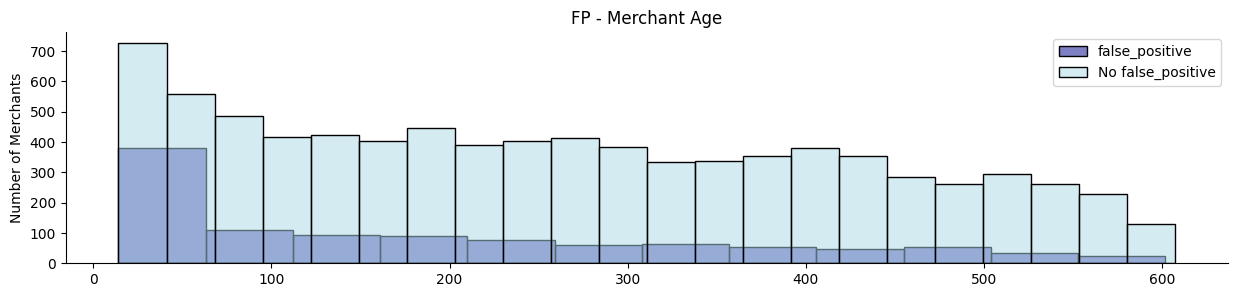

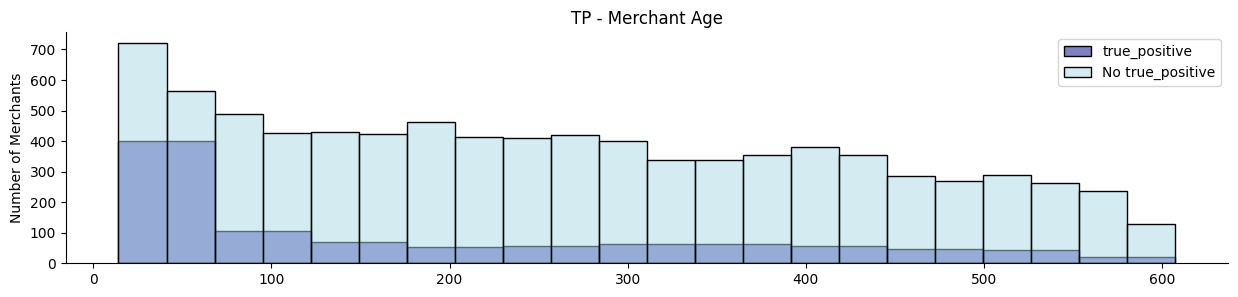

In [108]:
compare_dist(test, 'merchant_age', 'false_positive', 'FP - Merchant Age', '', 'Number of Merchants')
compare_dist(test, 'merchant_age', 'true_positive', 'TP - Merchant Age', '', 'Number of Merchants')

In [109]:
compare_dist(test, 'avg_tx_freq_rank', 'false_positive', 'FP - Average Transaction Frequency  Rank', '', 'Number of Merchants')
compare_dist(test, 'avg_tx_freq_rank', 'true_positive', 'TP - Average Transaction Frequency  Rank', '', 'Number of Merchants')

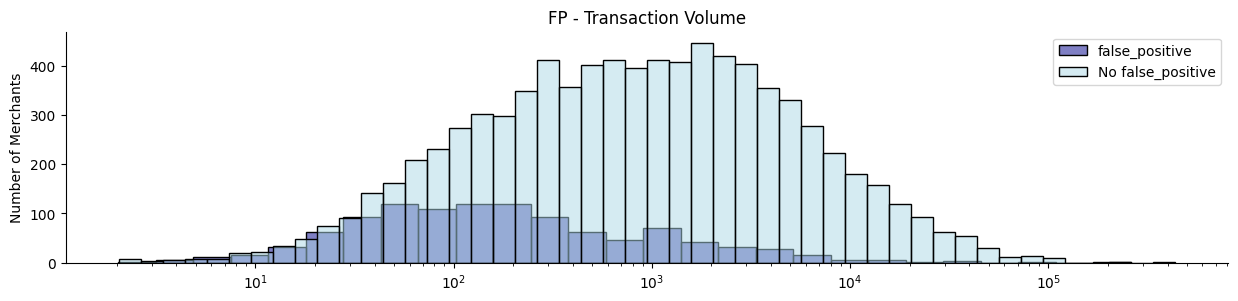

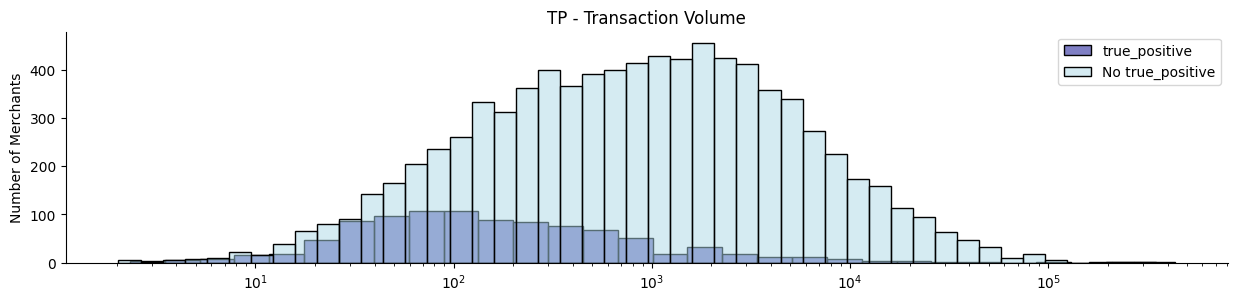

In [110]:
compare_dist(test, 'total_tx_volume', 'false_positive', 'FP - Transaction Volume', '', 'Number of Merchants', log_scale=True)
compare_dist(test, 'total_tx_volume', 'true_positive', 'TP - Transaction Volume', '', 'Number of Merchants', log_scale=True)

## Directional Correctness

When it comes to modeling time, it's hard to get the time horizons exactly right, since so many other factors influence when a merchant ends up churning. It's possible that a merchant churns, just maybe a bit earlier or later than we predicted. 

In checking for this, we observe that ~5% of the merchants we incorrectly said were going to churn, did actually churn in our two month period, and ~17% of the merchants we predicted as not churning, actually had a period of activity on the platform in that same period.

In [111]:
fpm = test[test['false_positive'] == 1]['merchant'].unique()
test[test['merchant'].isin(fpm)]['churn'].value_counts(normalize=True)

churn
0    0.949538
1    0.050462
Name: proportion, dtype: float64

In [112]:
fpmn = test[(test['merchant'].isin(fpm)) & (test['churn'] == 1)]['merchant'].unique()
test[test['merchant'].isin(fpmn)][['merchant', 'period', 'churn', 'churn_predicted']][:10]

merchant   period  churn  churn_predicted
170  05a96cf0b0  2034-07      1                1
171  05a96cf0b0  2034-08      0                1
243  07f6e186bc  2034-07      0                1
244  07f6e186bc  2034-08      1                0
254  085675f973  2034-07      0                1
255  085675f973  2034-08      1                1
433  0cde374cf3  2034-07      1                1
434  0cde374cf3  2034-08      0                1
719  14fb37c54a  2034-07      0                1
720  14fb37c54a  2034-08      1                0

In [113]:
fnm = test[test['false_negative'] == 1]['merchant'].unique()
test[test['merchant'].isin(fnm)]['churn'].value_counts(normalize=True)

churn
1    0.836138
0    0.163862
Name: proportion, dtype: float64

In [114]:
fnmn = test[(test['merchant'].isin(fnm)) & (test['churn'] == 0)]['merchant'].unique()
test[test['merchant'].isin(fnmn)][['merchant', 'period', 'churn', 'churn_predicted']][:10]

merchant   period  churn  churn_predicted
0    000ed1585f  2034-07      1                0
1    000ed1585f  2034-08      0                0
72   029b8d26b9  2034-07      0                0
73   029b8d26b9  2034-08      1                0
131  042cfb087c  2034-07      0                0
132  042cfb087c  2034-08      1                0
154  05368eca16  2034-07      1                0
155  05368eca16  2034-08      0                0
162  0587f9bbc5  2034-07      0                0
163  0587f9bbc5  2034-08      1                0

# Shortcomings

Given the limited dataset, the model's performance isn't as strong as it needs to be to be used in production. Augmenting the featureset with additional data would help us perform better.

As a function of the problem space, the model can't be very precise about when exactly a merchant will churn, though it can say that all signs point to the merchant churning in the near future.

It can also give us limited lead time before a merchant churns. Since so many merchants go weeks and months between transactions, the model's prediction frequency can only be so far removed from the final transaction to maintain accuracy

# Usage

Given that the model's performance isn't very strong, we'll have to be careful about how we use it. We could:
- Use its predictions as indicators of a merchant's risk of churn, as input into other decision making processes, as opposed its predictions driving decision making on their own
- Use the emergent patterns predictive of churn to better understand drivers of retention risk, and build around those for our project strategy

While the model performance isn't much better than the heuristic baseline, it gives us the ability to balance precision and recall, a way to understand the drivers of churn from the data, and the ability to expand to other datasets once they become available. As such, it's still a good foundation for future work.

# Improvements

We need to add more and varied datasets to complement the transaction history. Metadata about product category, region, information about the user base, indicators of quality like chargebacks, history of customer support requests, markers of inorganic behavior would all be very useful here.